Preamble

In [1]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import numpy.ma as ma


from mpl_toolkits.axes_grid1 import make_axes_locatable #for subplot colorbars
from matplotlib.pyplot import cm

# configure plotting
%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (6, 6 / 1.6), 'font.size': 8, \
                            'figure.facecolor': (1, 1, 1, 0),'font.sans-serif':'Latin Modern Math'}

from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

%matplotlib inline


# Calculating the G, the normalized correlation function

In [110]:
def Calculate_G(image_names, start, time, lags):
    "this function takes image names, a sequence of time and a desired amount of lags"
    "and calculates G, mean quantities, maps"

    def calculate_G(metapixels_a, metapixels_b):
        "this function calculates the value of the normalized correlation"
        "function between metapixels"
        a = np.nanmean((metapixels_a * metapixels_b), axis=(2, 3))
        b = np.nanmean(metapixels_a, axis=(2, 3))
        c = np.nanmean(metapixels_b, axis=(2, 3))
        d = np.nanstd(metapixels_a, axis=(2, 3))
        e = np.nanstd(metapixels_b, axis=(2, 3))

        G = (a - (b * c)) / (d * e)
        return G

##################################################################################################################
#this variable is a list which contains each timestep

    G_time_lags = [[] for _ in range(len(time))]
    sandpile_mean = [[] for _ in range(len(time))]
    sandpile_var = [[] for _ in range(len(time))]

    i = 0

    # this is the size of the metapixels, defined outside of the loop
    size = 6

    for t in time:
        #this is just to make t an interger rather than a float so that t can be used as a list index
        t = int(t)

        #the index of each image (i.e. the frame number) is the iterator t plus start, the time where grains first
        #enter the frame
        speckle_a = Image.open(image_names[t + start])
        speckle_a = np.asarray(speckle_a)[y_min:y_max, x_min:x_max]

        lenr, lenc = int(speckle_a.shape[0] / size), int(speckle_a.shape[1] /
                                                         size)
        metapixels_a = speckle_a.reshape(lenr, size, lenc,
                                         size).transpose(0, 2, 1, 3)

        mp_a_mean = np.nanmean(metapixels_a, axis=(2, 3))
        metapixels_a = np.subtract(metapixels_a,
                                   mp_a_mean[..., np.newaxis, np.newaxis])
##################################################################################################################
        l = 0
        G_lags = [[] for _ in range(lags)]

        # this loop is for each lag
        for lag in range(lags):

            # choosing two speckle images
            speckle_b = Image.open(image_names[lag + t + start])
            speckle_b = np.asarray(speckle_b)[y_min:y_max, x_min:x_max]

            metapixels_b = speckle_b.reshape(lenr, size, lenc,
                                             size).transpose(0, 2, 1, 3)
            mp_b_mean = np.nanmean(metapixels_b, axis=(2, 3))
            metapixels_b = np.subtract(metapixels_b, 
                                       mp_b_mean[..., np.newaxis, np.newaxis])

            frame = (calculate_G(metapixels_a, metapixels_b))
            #applying the mask to remove the background
            G_lags[l] = ma.masked_array(frame, mask=mask)

            l += 1
##################################################################################################################
        G_time_lags[i] = G_lags
    
        i += 1
        print(t+start)

    return G_time_lags

# Loading images

In [111]:
os.chdir(
    '/media/nakul/Seagate Portable Drive/Data/DWS_Creep/DWS_RawExperimentPhotos/Boundaries/Flat_Smooth/02_10_2022/02_10_2022_A'
)

In [112]:
import glob
import natsort

image_names = []

for name in glob.glob('img_*.jpg'):
    image_names.append(name)

image_names = natsort.natsorted(image_names,reverse=False)
timestep = len(image_names)

# Creating masks

In [113]:
#specify the bounds of the image - should be evenly divisible by the metapixel size
x_min = 0
x_max = 2040
y_min = 0
y_max = 1092

# choosing two speckle images
speckle_a = Image.open(image_names[110])
speckle_a = np.asarray(speckle_a)[y_min:y_max,x_min:x_max]

speckle_b = Image.open(image_names[100])
speckle_b = np.asarray(speckle_b)[y_min:y_max,x_min:x_max]
    
# partitioning images into metpixels
size = 6

a = speckle_a
lenr, lenc = int(a.shape[0]/size), int(a.shape[1]/size)
## 'flattening' the metapixel array along a single axis
metapixels_a = speckle_a.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)

b = speckle_b
lenr, lenc = int(b.shape[0]/size), int(b.shape[1]/size)
metapixels_b = speckle_b.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)
    
metapixel_grid_rows = metapixels_a.shape[0]
metapixel_grid_columns = metapixels_a.shape[1]
metapixel_grid_area = metapixel_grid_rows*metapixel_grid_columns

mp_a_mean = np.mean(metapixels_a,axis = (2,3))
mp_b_mean = np.mean(metapixels_b,axis = (2,3))

## Adding [...,np.newaxis,np.newaxis] allows the array of means to be subtracted
## from the array containing metapixels. otherwise, their shapes are not the same
metapixels_a = np.subtract(metapixels_a,mp_a_mean[..., np.newaxis,np.newaxis])
metapixels_b = np.subtract(metapixels_b,mp_b_mean[..., np.newaxis,np.newaxis])

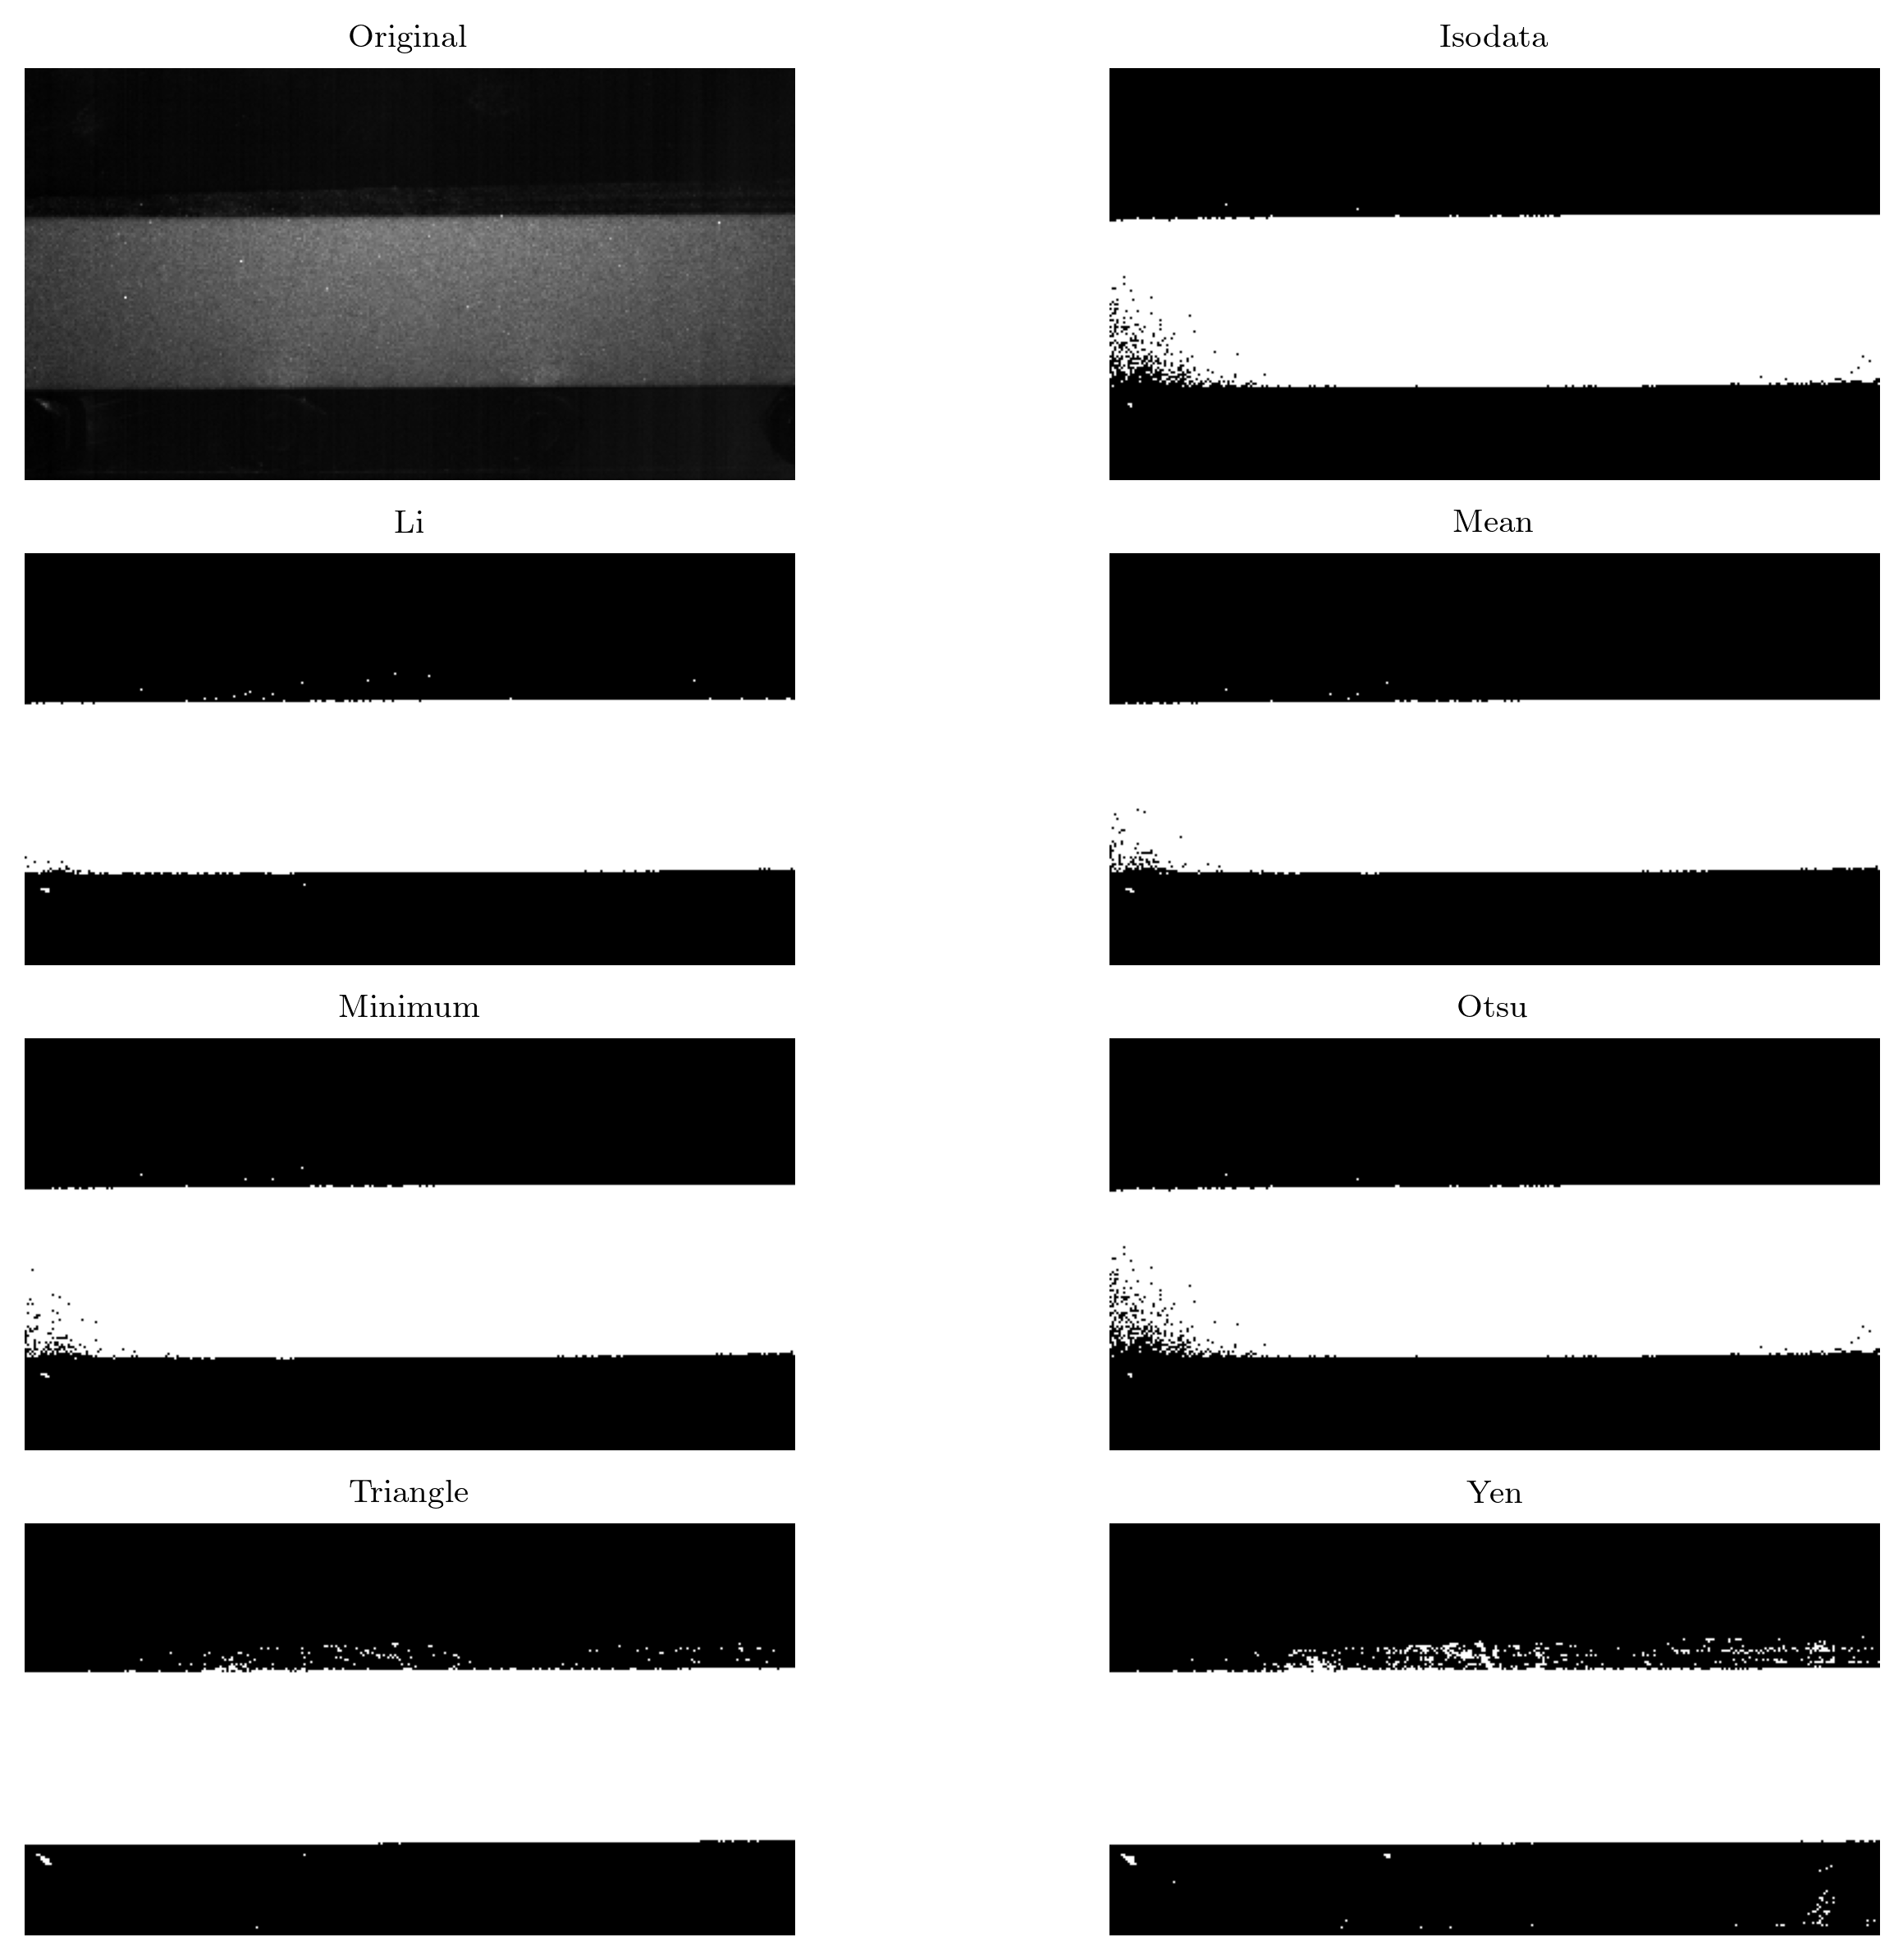

In [114]:
from skimage.filters import try_all_threshold

img = mp_a_mean

# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)


plt.show()

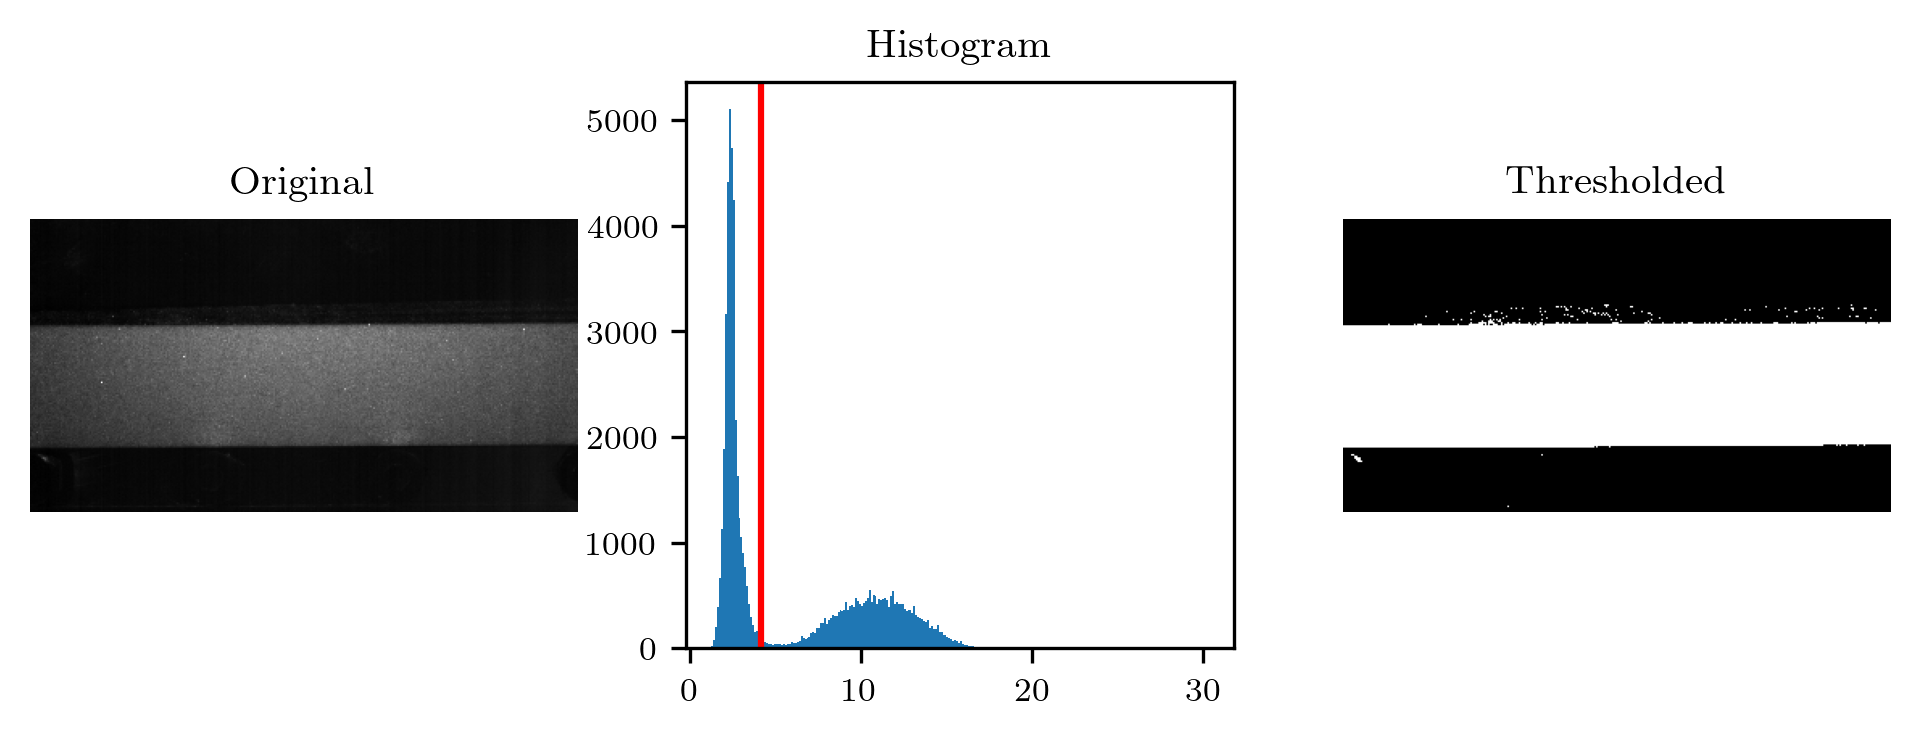

In [115]:
from skimage.filters import threshold_triangle

image = mp_a_mean
thresh = threshold_triangle(image)
binary = image > thresh
mask = ~binary

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

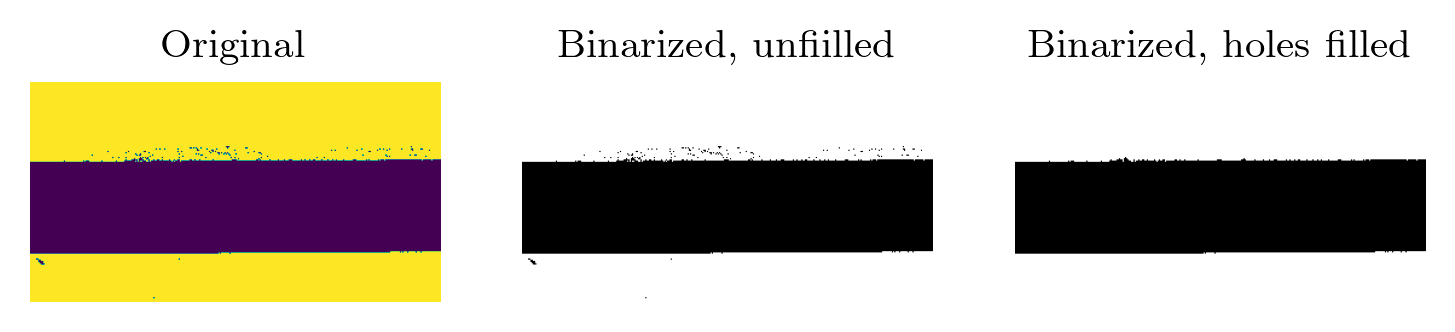

In [116]:
from scipy import ndimage as ndi

#recursively filling holes to create a cleaner mask

fill_a = ndi.binary_fill_holes(binary)
fill_b = ndi.binary_fill_holes(~fill_a)
fill_c = ndi.binary_fill_holes(fill_b)


ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)


ax1.imshow(~binary)
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(~binary, cmap=plt.cm.gray)
ax2.set_title('Binarized, unfiilled')
ax2.axis('off')

ax3.imshow(fill_c, cmap=plt.cm.gray)
ax3.set_title('Binarized, holes filled')
ax3.axis('off')

mask = fill_c

# Calculating G

In [12]:
# time_cumulative = list(np.logspace(1, 13, num=13, base=2))
time_cumulative = list(np.logspace(1, 10, num=10, base=2))
time_cumulative.insert(0,0)

time_instantaneous = np.arange (0,100,1)

# correlation_maps_cumulative = Calculate_G(image_names,53,time_cumulative,100)
# correlation_maps_instantaneous = Calculate_G(image_names,53,time_instantaneous,2)

## Saving data

In [118]:
os.chdir(
    '/media/nakul/Seagate Portable Drive/Data/DWS_Creep/DWS_Correlation_Outputs/Boundaries/FlatSmooth/02_10_2022/02_10_2022_A'
)

In [119]:
np.savez(
    'FlatSmooth_02_10_2022_A',
    data1 = correlation_maps_cumulative,
    data2 = correlation_maps_instantaneous,
    data3 = fill_c)

## Loading Data

In [3]:
os.chdir(
    '/media/nakul/SanDisk'
)

data = np.load('FlatSmooth_02_10_2022_A.npz')
correlation_maps_cumulative = data['data1']
# GlassBeads_May132021_A_correlation_maps_instantaneous = GlassBeads_May132021_A['data2']
mask = data['data3']

## Maps of instantaneous strain

/tmp/ipykernel_7784/1375105684.py:25: RuntimeWarning: divide by zero encountered in log
  masked_map = -(np.log(masked_map)/c)
/tmp/ipykernel_7784/1375105684.py:25: RuntimeWarning: invalid value encountered in log
  masked_map = -(np.log(masked_map)/c)
/tmp/ipykernel_7784/1375105684.py:28: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad('white',1.)


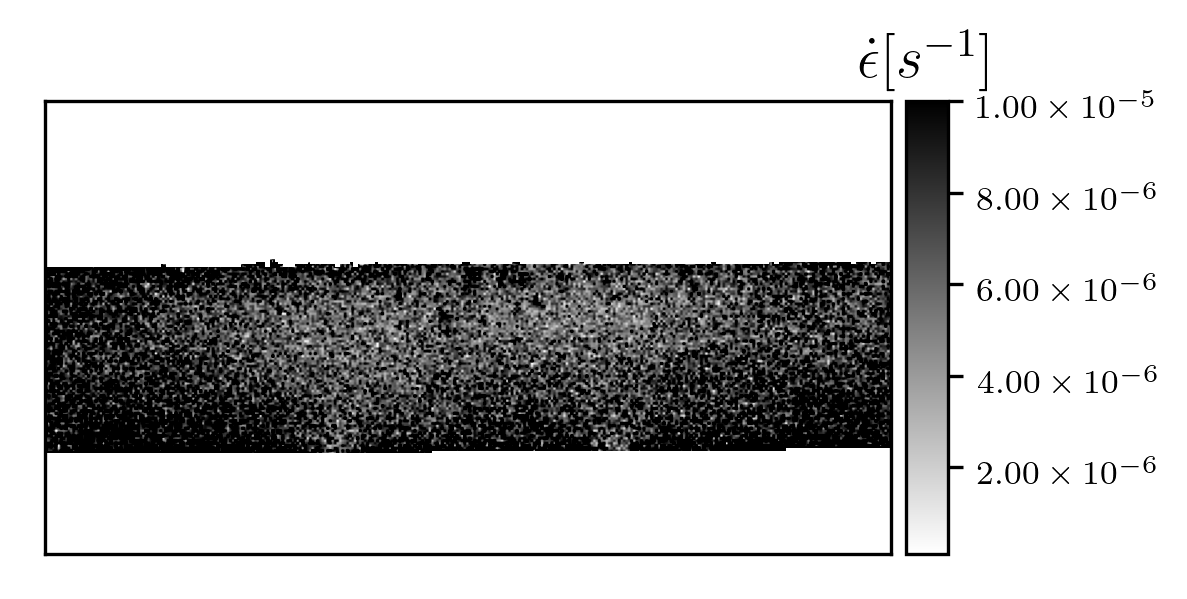

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

cmap = 'gray_r'

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

########################################################################################
fig = plt.figure(figsize=(6, 2))
ax1 = plt.subplot(1, 1, 1)
########################################################################################
frame = correlation_maps_cumulative[8][10]
masked_map = ma.masked_array(frame, mask=mask)
masked_map[masked_map <= 0] == 0.00000000000000001
masked_map = -(np.log(masked_map)/c) 
im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = cmap)
cmap = plt.cm.gray
cmap.set_bad('white',1.)
########################################################################################
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical',format=ticker.FuncFormatter(fmt))
# cax.tick_params(labelsize=15) 
cax.set_title(r'$\dot{\epsilon}[s^{-1}]$',fontsize = 14)
ax1.set_xticks([]);
ax1.set_yticks([]);
########################################################################################
# plt.savefig('/home/nakul/Documents/Python Scripts/DWS_Creep/MaterialsBoundaries/Boundaries/Bedform/Bedform_02_07_2022_E_strainmap', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(6, 2))

from mpl_toolkits.axes_grid1 import make_axes_locatable
l = 3.3 * 100000
c = ((8 * np.pi) * (np.sqrt(2 / 5)) * l) / 633
n = 0
time = np.arange(0, 1000, 1)

for i in range(99):

    ########################################################################################
    fig = plt.figure(figsize=(6, 2))
    ax1 = plt.subplot(111)
    ########################################################################################
    frame = correlation_maps_instantaneous[i][1]
    masked_map = ma.masked_array(frame, mask=mask)
    masked_map[masked_map <= 0] == 0.0000000000000000000001
    masked_map = -(np.log(masked_map) / c)
    im1 = ax1.imshow(masked_map, vmin=1e-7, vmax=1e-5, cmap='inferno_r')
    cmap = plt.cm.gray
    cmap.set_bad('white', 1.)
    ########################################################################################
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1,
                 cax=cax,
                 orientation='vertical',
                 format=ticker.FuncFormatter(fmt))
    # cax.tick_params(labelsize=15)
    cax.set_title(r'$\dot{\epsilon}[s^{-1}]$', fontsize=14)

    ax1.set_xticks([])
    ax1.set_yticks([])
    ########################################################################################
    fig.tight_layout()

    plt.savefig(
        "/home/nakul/Documents/Python Scripts/DWS_Creep/MaterialsBoundaries/Boundaries/Bedform/StrainMovie_02_07_2022_A/img_"
        + str(n) + ".png",
        format="PNG")
    plt.clf()
    n += 1

In [9]:
def wholefield_stats(spatial_map,mask):
    
    n = len(spatial_map)
    G_mean = [[] for _ in range(n)]
    χ4 = [[] for _ in range(n)]
    
    for i in range(n):
        map_mean = []
        map_var = []
        temp_map = spatial_map[i]
        
        for j in range(len(temp_map)):
            masked_map = ma.masked_array(temp_map[j], mask= mask)
            map_mean.append(np.nanmean(masked_map))
            map_var.append(np.nanvar(masked_map))
            
        map_mean = np.asarray(map_mean)
        map_var = np.asarray(map_var)
        
        χ4[i] = map_var
        G_mean[i] = map_mean 
    return G_mean#,χ4

In [10]:
G_mean = wholefield_stats(correlation_maps_cumulative ,mask)

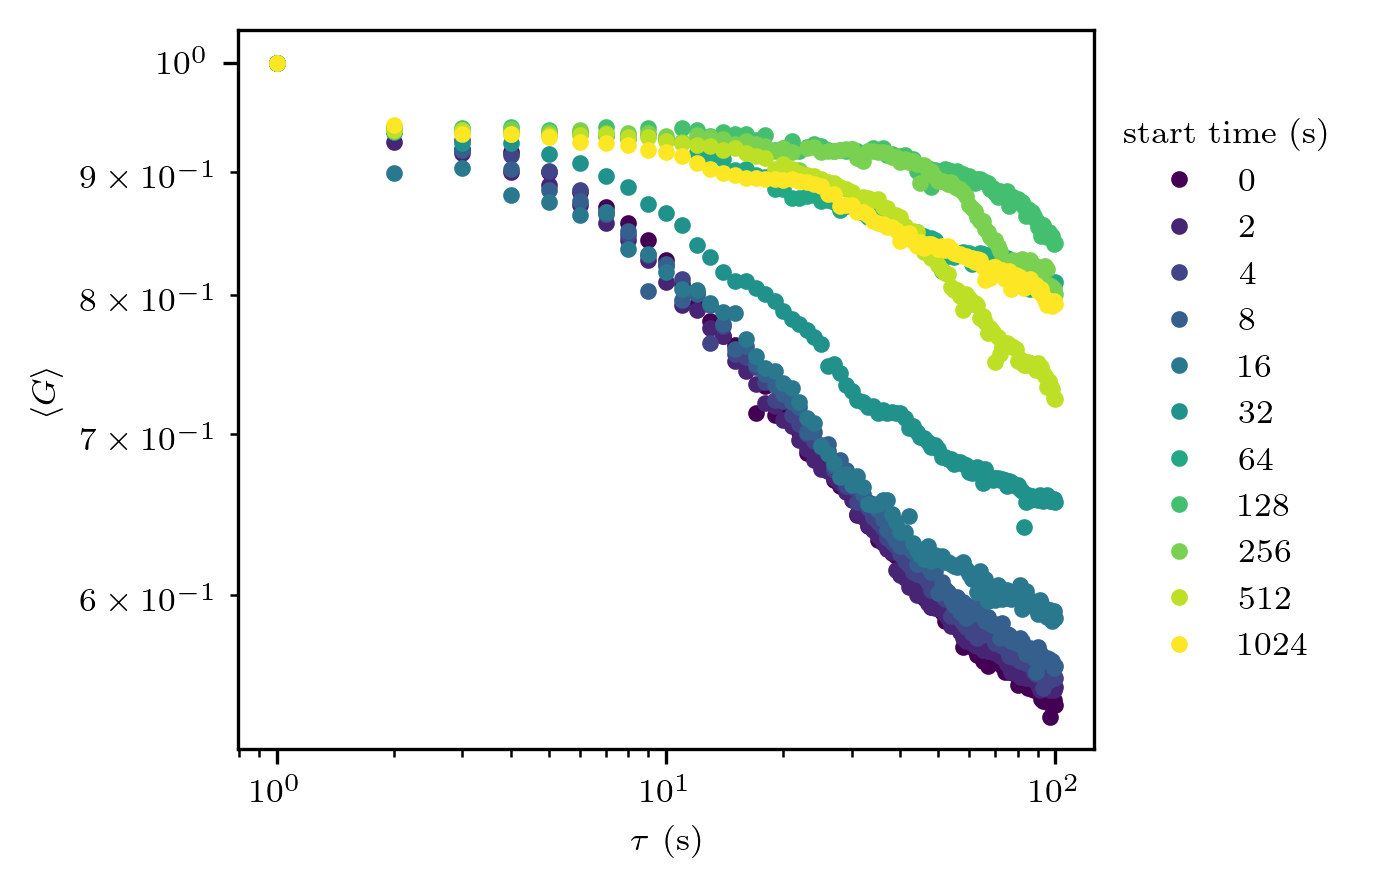

In [29]:
from matplotlib.pyplot import cm

labels = list(time_cumulative)

color = iter(cm.viridis(np.linspace(0, 1, 11)))
time = np.arange(1, 101, 1)

fig = plt.figure(figsize=(4, 3))
ax1 = plt.subplot(111)

for t in range(11):
    c = next(color)
    ax1.plot(time,
             G_mean[t],
             'o',
             color=c,
             markersize=3,
             alpha=1,
             label=int(labels[t]))
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r'$ \tau $ (s)')
ax1.set_ylabel(r'$ \langle G \rangle$')
box = ax1.get_position()
lgd = ax1.legend()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax1.legend(title='start time (s)',
           loc='center left',
           frameon=False,
           bbox_to_anchor=(1, 0.5))

plt.tight_layout()
# plt.savefig(
#     '/home/nakul/Documents/Python Scripts/DWS_Creep/MaterialsBoundaries/Boundaries/Bedform/Bedform_02_07_2022_E_correlation',
#     bbox_inches='tight')

In [73]:
# ensuring that G goes from 0 to 1
g = G_mean
d = np.min(g)
gp = (g-d)/(1-d)

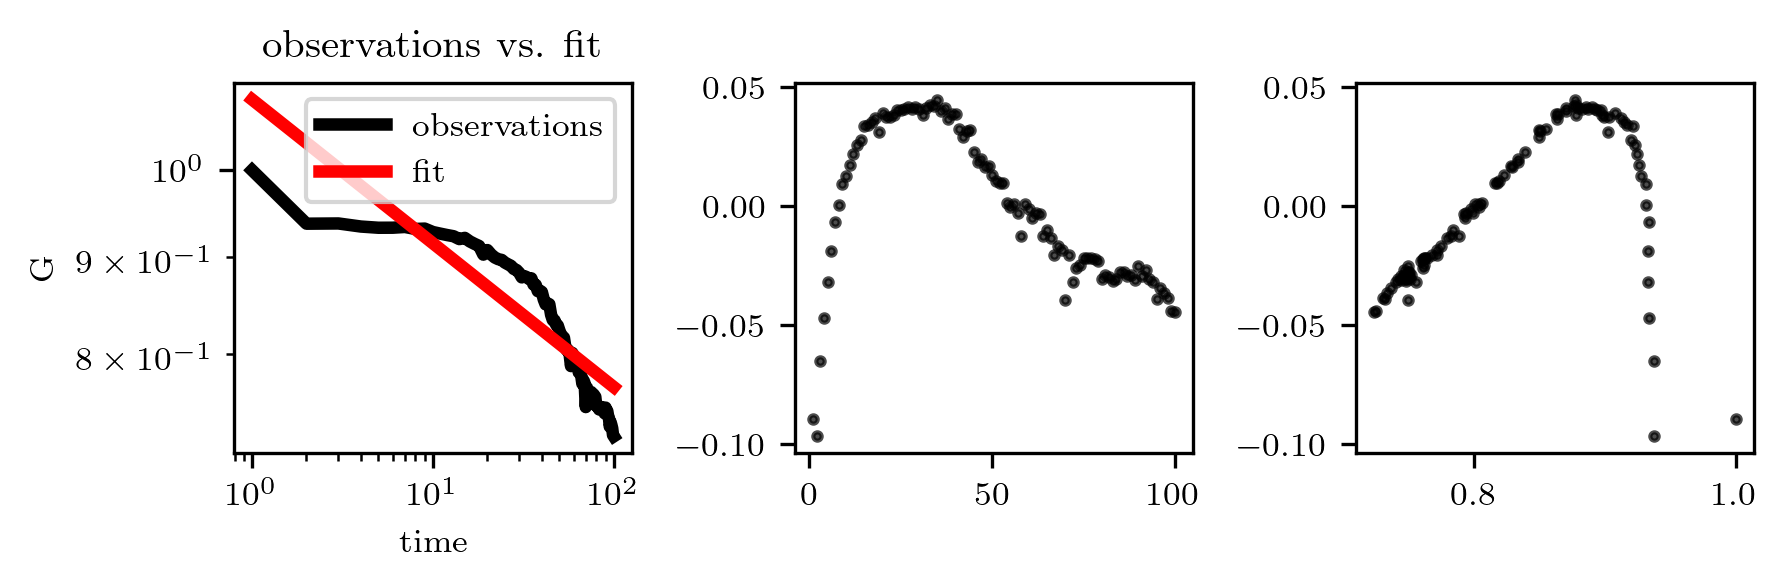

In [130]:
from scipy.optimize import curve_fit

# def exponential_fit(x,τ):
#     return  np.exp(x / τ)

# def log_fit(t,a,tau):
#     return -a*np.log( 1 + tau / t)

def exponential_fit(x,a,power):
    return a*(x**power)
 

fig = plt.figure(figsize=(6, 2))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

xdata = np.arange(1, 101, 1)
ydata = G_mean[9]
# a = np.max(ydata)

parameters, parameterscov = curve_fit(exponential_fit, xdata, ydata)#, bounds=(0,1))

y_fit = exponential_fit(xdata,*parameters)

ax1.plot(xdata,ydata, 'k',linewidth = 3,label = 'observations')
ax1.plot(xdata,y_fit,'r', linewidth = 3,label = 'fit')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel('time')
ax1.set_ylabel('G')
ax1.set_title('observations vs. fit')
ax1.legend()

ax2.plot(xdata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)
ax3.plot(ydata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)

plt.tight_layout()

In [150]:
parameters[1]

-0.05095266540784056

In [132]:
xdata = np.arange(1, 101, 1)
n = 11
yfits = [[] for _ in range(n)]
ydata = [[] for _ in range(n)]

for i in range(n):
    ydata[i] = G_mean[i] 
    parameters, parameterscov = curve_fit(exponential_fit, xdata, ydata[i])#, bounds=(0,1))
    yfits[i] = exponential_fit(xdata,*parameters)

In [154]:
def t_efold_fit(correlation_function):
    
    xdata = np.arange(1, 101, 1)
    fitting_parameters = [[] for _ in range(n)]
    ydata = [[] for _ in range(n)]
    tau = []

    for i in range(n):    
        ydata[i] = correlation_function[i] 
        popt, pcov = curve_fit(exponential_fit, xdata, ydata[i])#, bounds=(0,1))
        fitting_parameters[i] = popt, pcov
        tau_temp = fitting_parameters[i][0][1]
#         tau_temp = np.rint(tau_temp)
        tau.append(tau_temp)
    return tau

In [155]:
Undisturbed_tau = t_efold_fit(G_mean)
Undisturbed_tau = np.asarray(Undisturbed_tau)

In [156]:
Undisturbed_tau

array([-0.15856224, -0.15355104, -0.15233277, -0.14644036, -0.13125432,
       -0.1080633 , -0.04881145, -0.02981963, -0.04442756, -0.07578195,
       -0.05095267])

Text(0.5, 0, '$tw$')

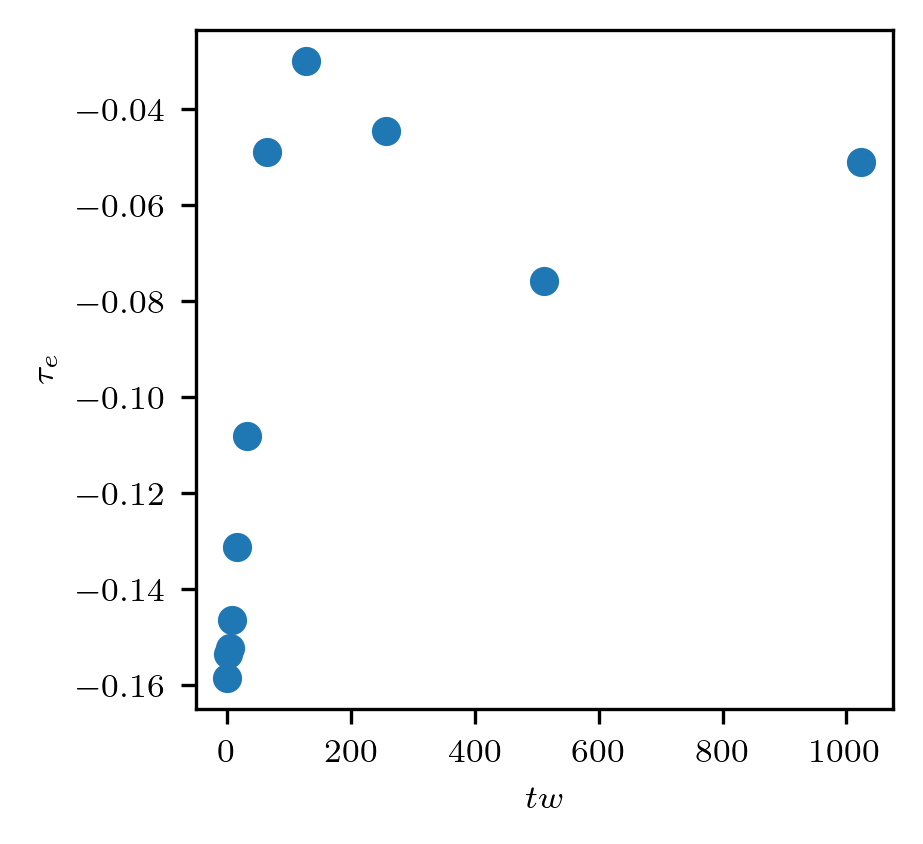

In [157]:
fig = plt.figure(figsize=(3, 3))
ax1 = plt.subplot(111)

ax1.plot(time_cumulative,Undisturbed_tau,'o')
# ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_ylabel(r'$\tau_e$')
ax1.set_xlabel('$tw$')

# ax1.set_ylim([1e0,1e2])

/tmp/ipykernel_7784/4176384831.py:6: RuntimeWarning: divide by zero encountered in power
  return a*(x**power)
/tmp/ipykernel_7784/4176384831.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.set_yscale('log')


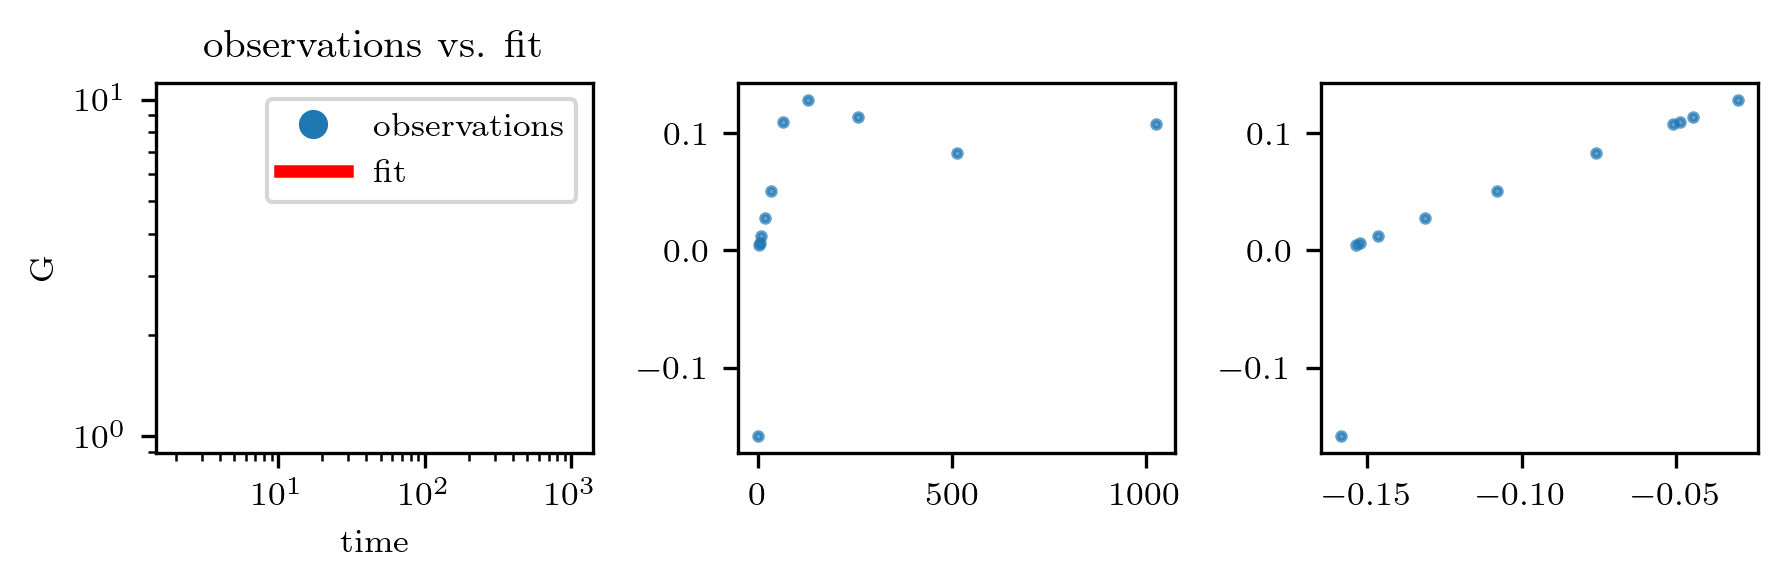

In [158]:
from scipy.optimize import curve_fit

a = np.min(Undisturbed_tau)

def powerlaw(x,power):
    return a*(x**power)

fig = plt.figure(figsize=(6, 2))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

#use these data to fit to the timescale extracted from the exponential fit
xdata = time_cumulative
ydata = Undisturbed_tau

parameters, parameterscov = curve_fit(powerlaw, xdata, ydata)#, bounds=(0,1))

y_fit = powerlaw(xdata,*parameters)

ax1.plot(xdata,ydata,'o', linewidth = 3,label = 'observations')
ax1.plot(xdata,y_fit,'r', linewidth = 3,label = 'fit')

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel('time')
ax1.set_ylabel('G')
ax1.set_title('observations vs. fit')
ax1.legend()

ax2.plot(xdata,ydata-y_fit,'o',alpha = 0.7, markersize = 2)
ax3.plot(ydata,ydata-y_fit,'o',alpha = 0.7, markersize = 2)

plt.tight_layout()

In [155]:
parameters

array([0.19391387])

In [156]:
# Assessing goodness of fit

residuals = ydata - powerlaw(xdata,*parameters)
## residual sum of squares
ss_res = np.sum(residuals**2)
# total sum of squares
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared 

0.45919025636174926

NameError: name 'Undisturbed_tau' is not defined

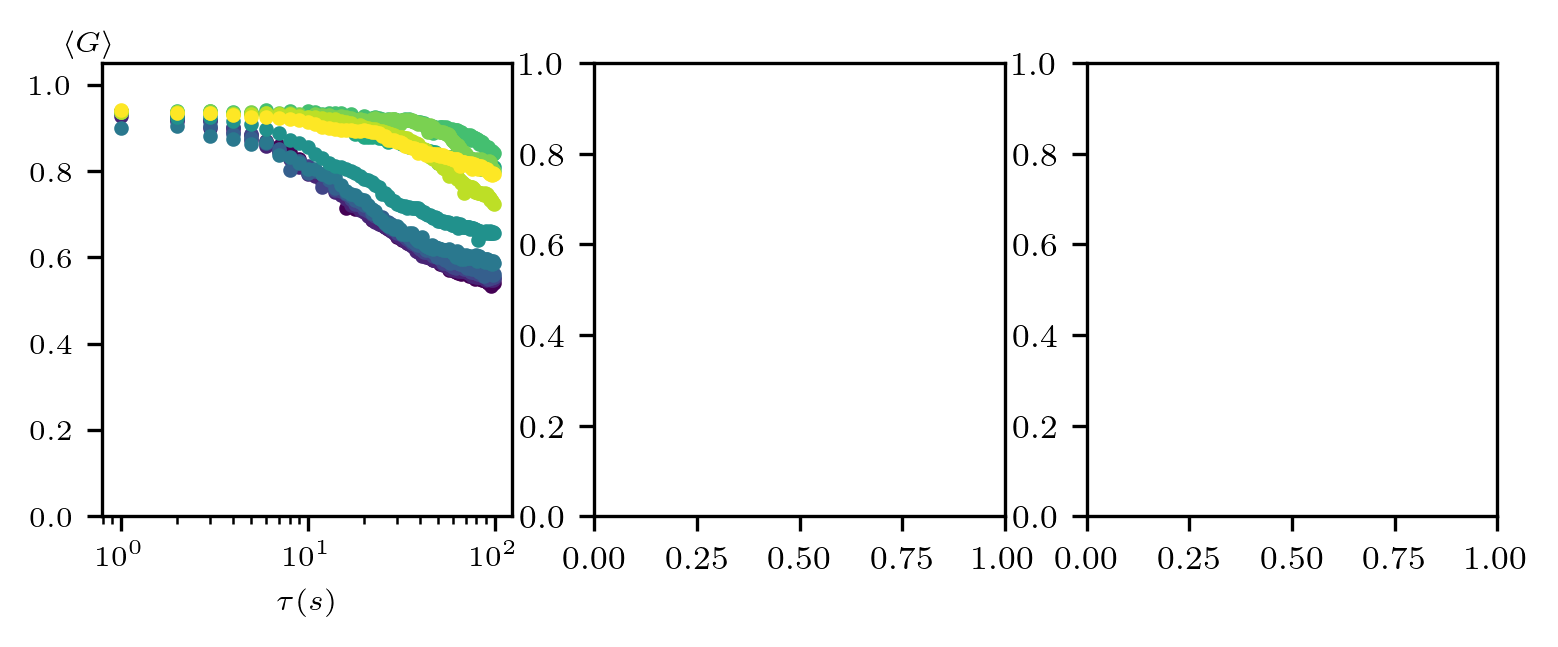

In [36]:
from matplotlib.pyplot import cm

fig = plt.figure(figsize=(6, 2))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

fs = 7
n = 11
################################################################################################################
color = iter(cm.viridis(np.linspace(0, 1, n)))

for t in range(n):
    c = next(color)
    ax1.plot(G_mean[t], 'o',color = c, markersize=2.5)

ax1.set_ylim([0, 1.05])
ax1.set_xscale('log')
ax1.set_xlabel(r'$ \tau (s)$', fontsize=fs)
ax1.set_ylabel(r'$ \langle G \rangle$', fontsize=fs, rotation='horizontal')
# ax1.yaxis.set_ticks([0, .5, 1])
ax1.yaxis.set_label_coords(-0.025, 1.01)
ax1.tick_params(axis='both', which='major', labelsize=fs)
# ax1.xaxis.set_ticks([1, 10, 100, 1000])
################################################################################################################
t = np.arange(1, 101)
color = iter(cm.viridis(np.linspace(0, 1, n)))

for i in reversed(range(n)):
    c = next(color)
    ax2.plot(t / Undisturbed_tau[i], G_mean[i], 'o',color = c,markersize=2.5)

ax2.set_ylim([0, 1.05])

ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.yaxis.set_ticks([])
ax2.set_xscale('log')

ax2.set_xticks([1e-5, 1e-3, 1e-1, 1e1])
ax2.set_xlabel(r'$ \tau / \tau_e  $', fontsize=fs)

#showing the stretched exponential form
x = np.arange(0.001, 20, .001)
y = np.exp((-x))
ax2.plot(x, y, '--r', label='exponential')
# ax2.plot(x,y,'r',linewidth = 2,label = r'$u/u_0 = e^{-z/\lambda}$')
# ax2.legend(frameon = False,loc = "lower left")
###############################################################################################################
t =  time_cumulative
labels =  time_cumulative
color = iter(cm.viridis(np.linspace(0, 1, n)))

for i in range(len(Undisturbed_tau)):
        c = next(color)
        ax3.plot(t[i],
             Undisturbed_tau[i],
             'o',
             color = c,
             markeredgecolor='k',
             markersize=6,
             label=int(labels[i]))
ax3.plot(t,y_fit,'--', linewidth = 3,label = 'fit')

ax3.set_xscale('log')
ax3.set_yscale('log')
# ax3.set_xlim([.1e0, 1e6])
# ax3.set_ylim([1e1, 1e4])
# ax3.set_xticks([1e-1, 1e2, 1e5])
# ax3.set_yticks([1e1, 1e4])

ax3.set_ylabel(r'$\tau_e$ (s)', fontsize=fs, rotation='horizontal')
ax3.yaxis.set_label_coords(0.1, 1.01)
ax3.set_xlabel('t (s)', fontsize=fs)
ax3.tick_params(axis='both', which='major', labelsize=fs)
# ax3.yaxis.tick_right()

lg = ax3.legend(title='start time (s)',
                ncol=2,
                loc='center left',
                frameon=False,
                bbox_to_anchor=(1, 0.5),
                fontsize=6)

plt.tight_layout()
#################################################################################################################
# fig.set_size_inches(7, 2.5)
# plt.savefig(
#     '/home/nakul/Documents/Python Scripts/DWS_Creep/MaterialsBoundaries/Boundaries/Bedform/Bedform_02_07_2022_E_timescales',
#     bbox_inches='tight')

# Profiles

## Functions


### Crop and rotate maps


In [159]:
def crop_rotate(a,mask):
    a[a <= 0] = 0.00000000001
    l = 3.3 * 100000
    c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
    
    mask = mask
    masked_map = ma.masked_array(a, mask=mask)
#     masked_map = -(np.log(masked_map)/c) 
    img = masked_map
    
    rotated_test = transform.rotate(img,rotation_angle,preserve_range = True,resize = True)
    rotated_mask = transform.rotate(mask,rotation_angle,preserve_range = True,resize = True)
    rotated_masked_image = ma.masked_array(rotated_test,mask = rotated_mask) 

    roi_verts = [[y_max,x_max],[y_min,x_max],[y_min, x_min], [y_max, x_min]]
    roi_verts.append(roi_verts[0])
    x_roi, y_roi = zip(*roi_verts) 

    cropped_rows = rotated_test[y_min:y_max,x_min:x_max].shape[0]
    
    return rotated_test[y_min:y_max,x_min:x_max]

### Computing depth-averaged quantities


In [160]:
def depth_average(correlation_map):
    x = len(correlation_map)
    timestep = len(correlation_map)
    
    G_mean_depth_averaged = [[] for _ in range(x)]
    G_var_depth_averaged = [[] for _ in range(x)]
    
    ROI_average = []
    ROI_var = []
    
    # this loop
    for t in range(timestep):
        
        G_map_temp = correlation_map[t]
        G_map_rotated = transform.rotate(G_map_temp,rotation_angle,preserve_range = True,resize = True)
        G_map_cropped = np.asarray(G_map_rotated[y_min:y_max,x_min:x_max])
        
        cropped_rows = G_map_cropped.shape[0]
        cropped_columns = G_map_cropped.shape[1]
        cropped_area = cropped_rows*cropped_columns
        
        ROI_average.append(np.nanmean(G_map_cropped))
        ROI_var.append(np.nanvar(G_map_cropped))
        
        G_mean_temp = []
        G_var_temp = []
        
        G_mean_temp = np.nanmean(G_map_cropped,axis = 1)
        G_var_temp = np.nanvar(G_map_cropped, axis = 1)
            
        G_mean_depth_averaged[t] = np.asarray(G_mean_temp)
        G_var_depth_averaged[t] = np.asarray(G_var_temp)
        
        del G_map_temp,G_map_rotated,G_map_cropped,G_mean_temp,G_var_temp

    return G_mean_depth_averaged,G_var_depth_averaged,ROI_average,ROI_var

### Exponential fitting


In [161]:
from scipy.optimize import curve_fit

def func(z, l):
    return np.exp(-z/l)

def goodness_of_fit(xdata,ydata,popt):
    residuals = ydata - func(xdata,*popt)
    ## residual sum of squares
    ss_res = np.sum(residuals**2)
    # total sum of squares
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    r_squared 
    return r_squared

### normalizing profiles


In [162]:
def normalize_profile(profile):
    # this gives a normalized profile
    profile_norm = profile/np.max(profile)
    profile_min = np.min(profile_norm)
    normalized = (profile_norm - profile_min)/(1-profile_min)
    return normalized

/tmp/ipykernel_7784/2492132609.py:9: RuntimeWarning: divide by zero encountered in log
  masked_map = -(np.log(masked_map)/c)
/tmp/ipykernel_7784/2492132609.py:9: RuntimeWarning: invalid value encountered in log
  masked_map = -(np.log(masked_map)/c)


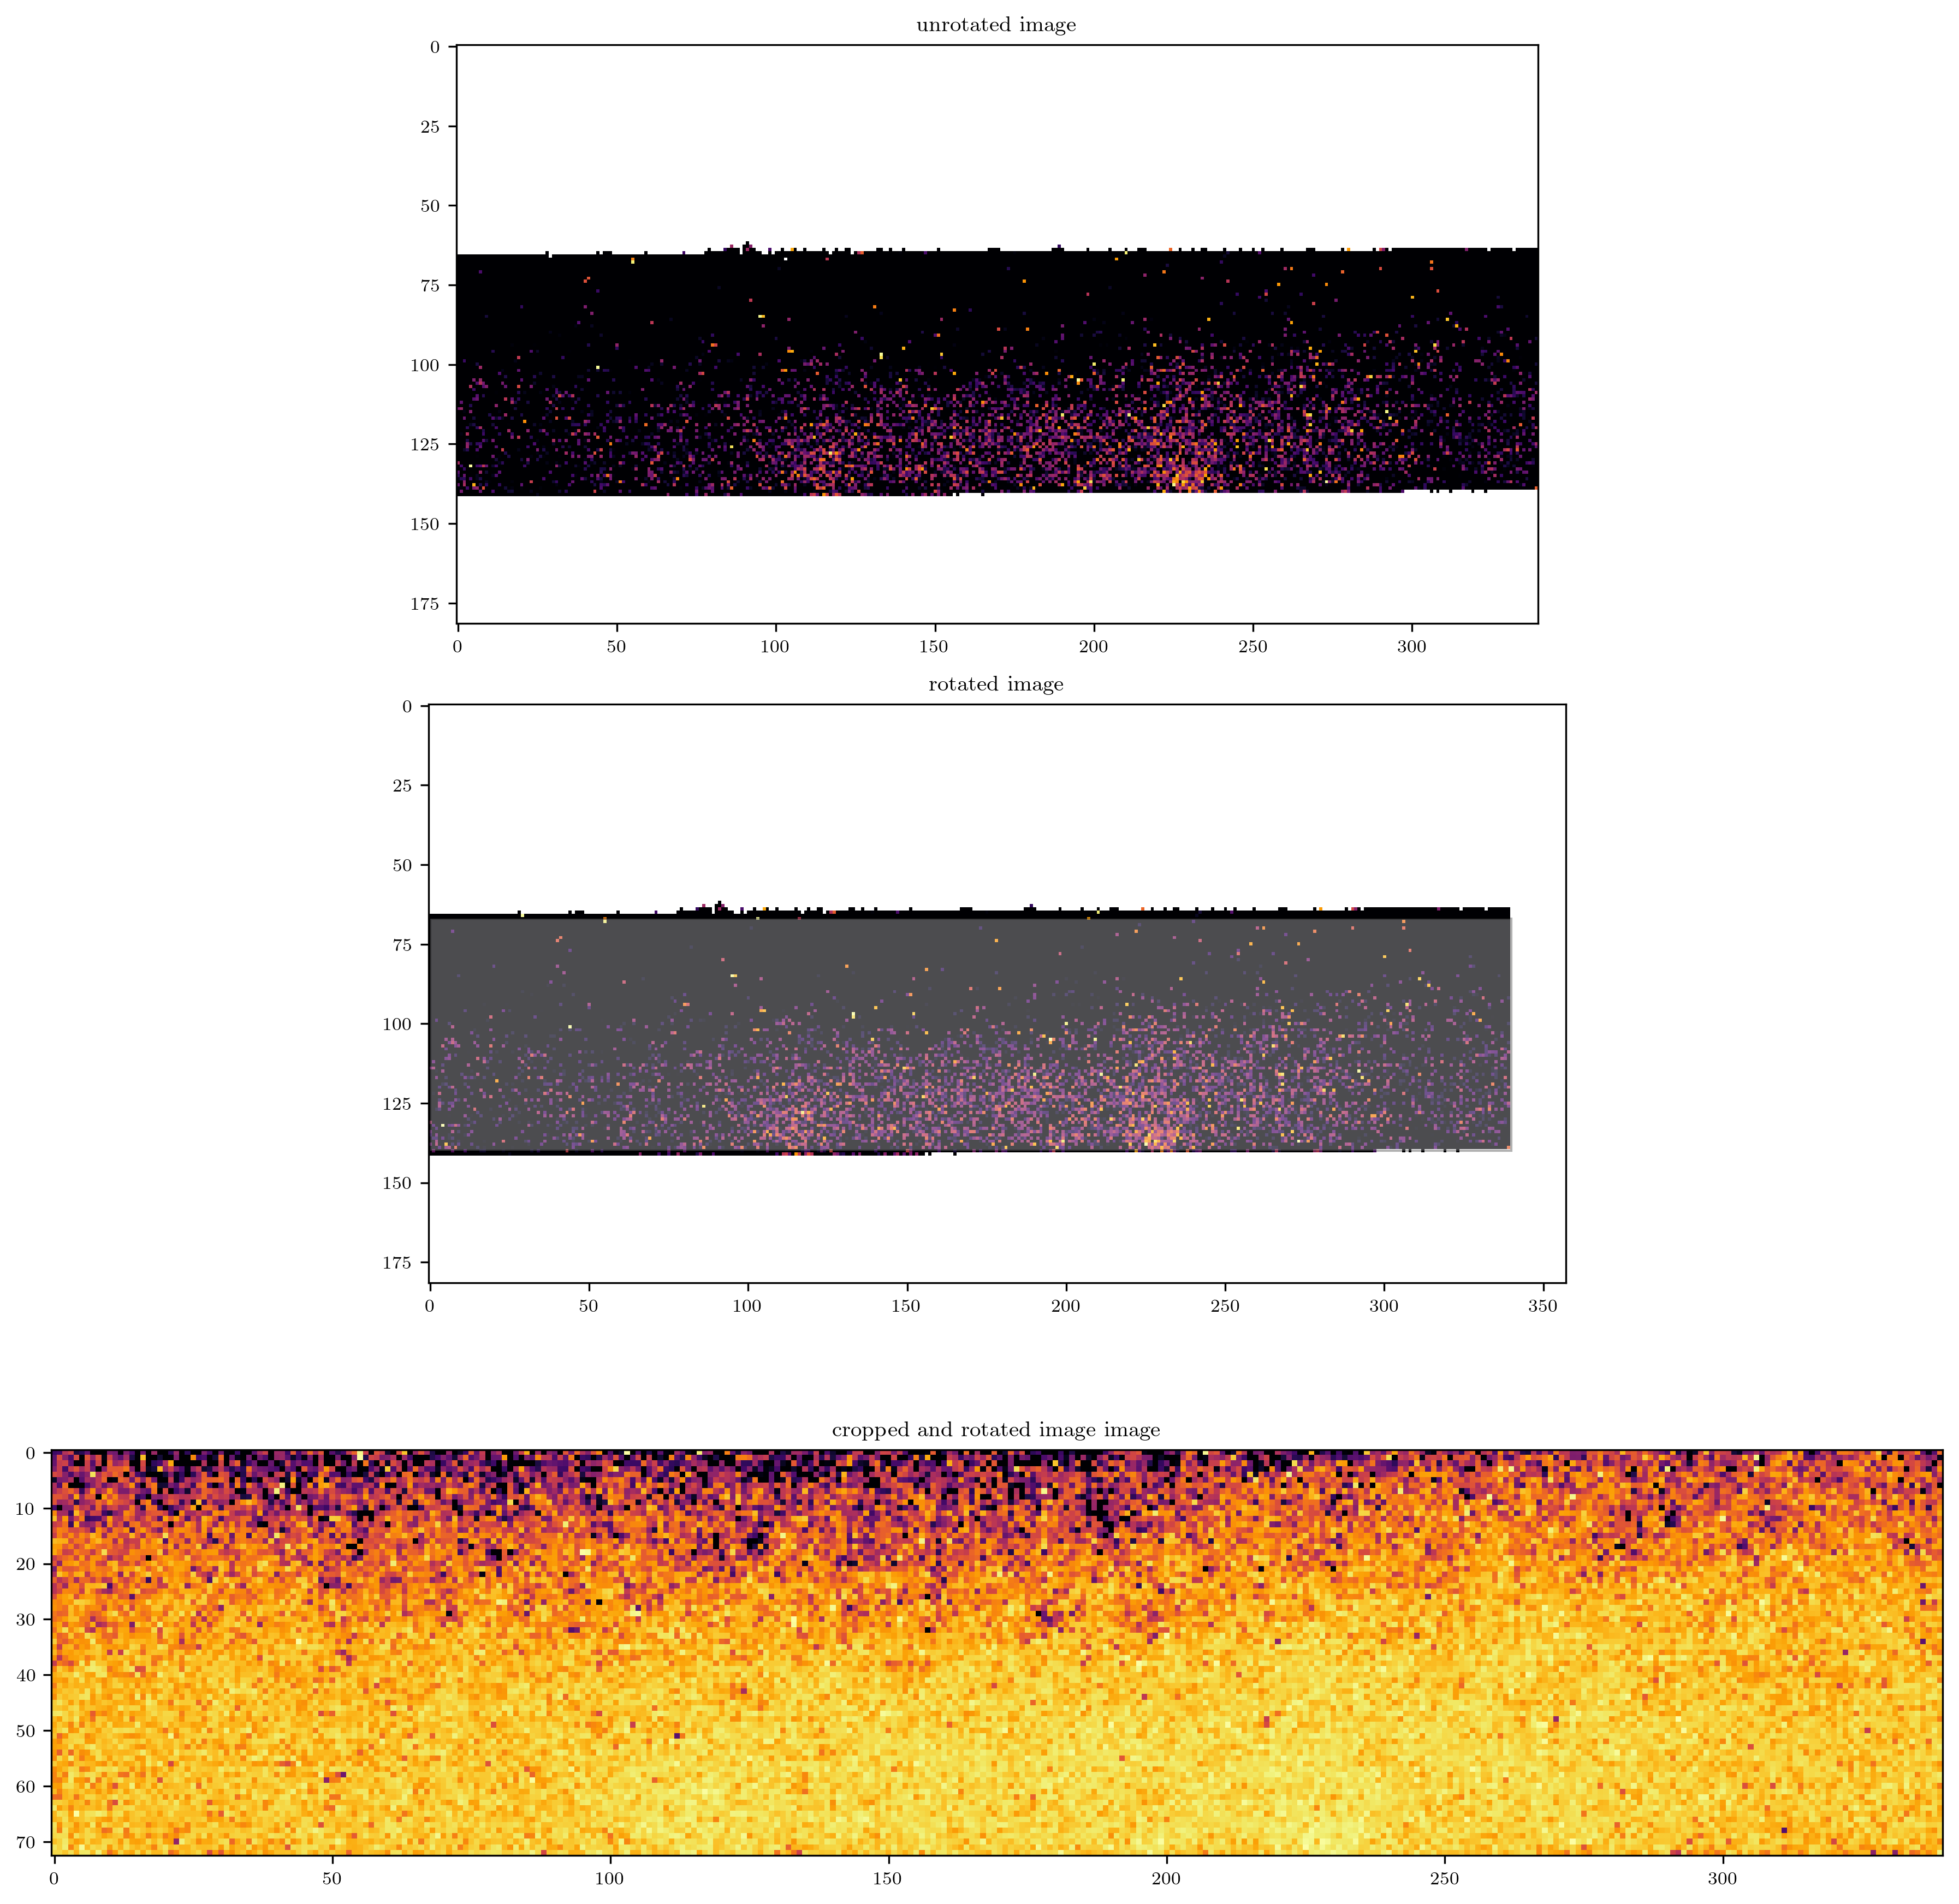

In [764]:
from skimage import transform

l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

frame = correlation_maps_cumulative[10][70]
masked_map = ma.masked_array(frame, mask = mask)
masked_map[masked_map <= 0] == .000000001
masked_map = -(np.log(masked_map)/c) 

img = masked_map

x_min = 0
x_max = 340
y_min = 67
y_max = 140

rotation_angle = 0

# this is the depth, in metapixels
z = np.arange(.5,(y_max-y_min),1)
#depth in pixels
z = z*6
#depth in meters
z = z*5.39e-5

rotated_test = transform.rotate(img,rotation_angle,preserve_range = True,resize = True)
rotated_mask = transform.rotate(mask,rotation_angle,preserve_range = True,resize = True)
rotated_masked_image = ma.masked_array(rotated_test,mask = rotated_mask) 

roi_verts = [[y_max,x_max],[y_min,x_max],[y_min, x_min], [y_max, x_min]]
roi_verts.append(roi_verts[0])
x_roi, y_roi = zip(*roi_verts) 

cropped_rows = rotated_test[y_min:y_max,x_min:x_max].shape[0]

###################################################################################
fig = plt.figure(figsize=(12,12))


ax1 = plt.subplot(311)
ax1.imshow(img,vmin = 1e-7,vmax = 1e-5,cmap = 'inferno_r')
# ax1.set_xlim([0,180])
# ax1.axis('off')
ax1.set_title('unrotated image')

ax2 = plt.subplot(312)
ax2.imshow(rotated_masked_image,vmin = 1e-7,vmax = 1e-5,cmap = 'inferno_r')
ax2.fill(y_roi,x_roi,'w',alpha = .3,edgecolor = 'k') 
# ax2.axis('scaled')
ax2.set_title('rotated image')
# ax2.axis('off')

ax3 = plt.subplot(313)
ax3.imshow(rotated_test[y_min:y_max,x_min:x_max],vmin = 1e-7,vmax = 1e-4,cmap = 'inferno_r')
ax3.set_title('cropped and rotated image image')
# ax3.axis('off')

plt.tight_layout()

# plt.savefig(
#     '/home/nakul/Documents/Python Scripts/DWS_Creep/MaterialsBoundaries/Figures/GlassBeads_May132021_A/GlassBeads_May132021_A_rotatedROI.png',
#     bbox_inches='tight')

In [719]:
#this is the number of measured waiting times
x = 11

mean_depth_avg = [[] for _ in range(x)]
var_depth_avg = [[] for _ in range(x)]
ROI_mean = [[] for _ in range(x)]
ROI_var = [[] for _ in range(x)]

for t in range(x):
    mean_depth_avg[t], var_depth_avg[t], ROI_mean[t], ROI_var[
        t] = depth_average(
            correlation_maps_cumulative[t])

/tmp/ipykernel_7784/4021352949.py:24: RuntimeWarning: divide by zero encountered in log
  masked_map = -(np.log(masked_map)/c)
/tmp/ipykernel_7784/4021352949.py:24: RuntimeWarning: invalid value encountered in log
  masked_map = -(np.log(masked_map)/c)


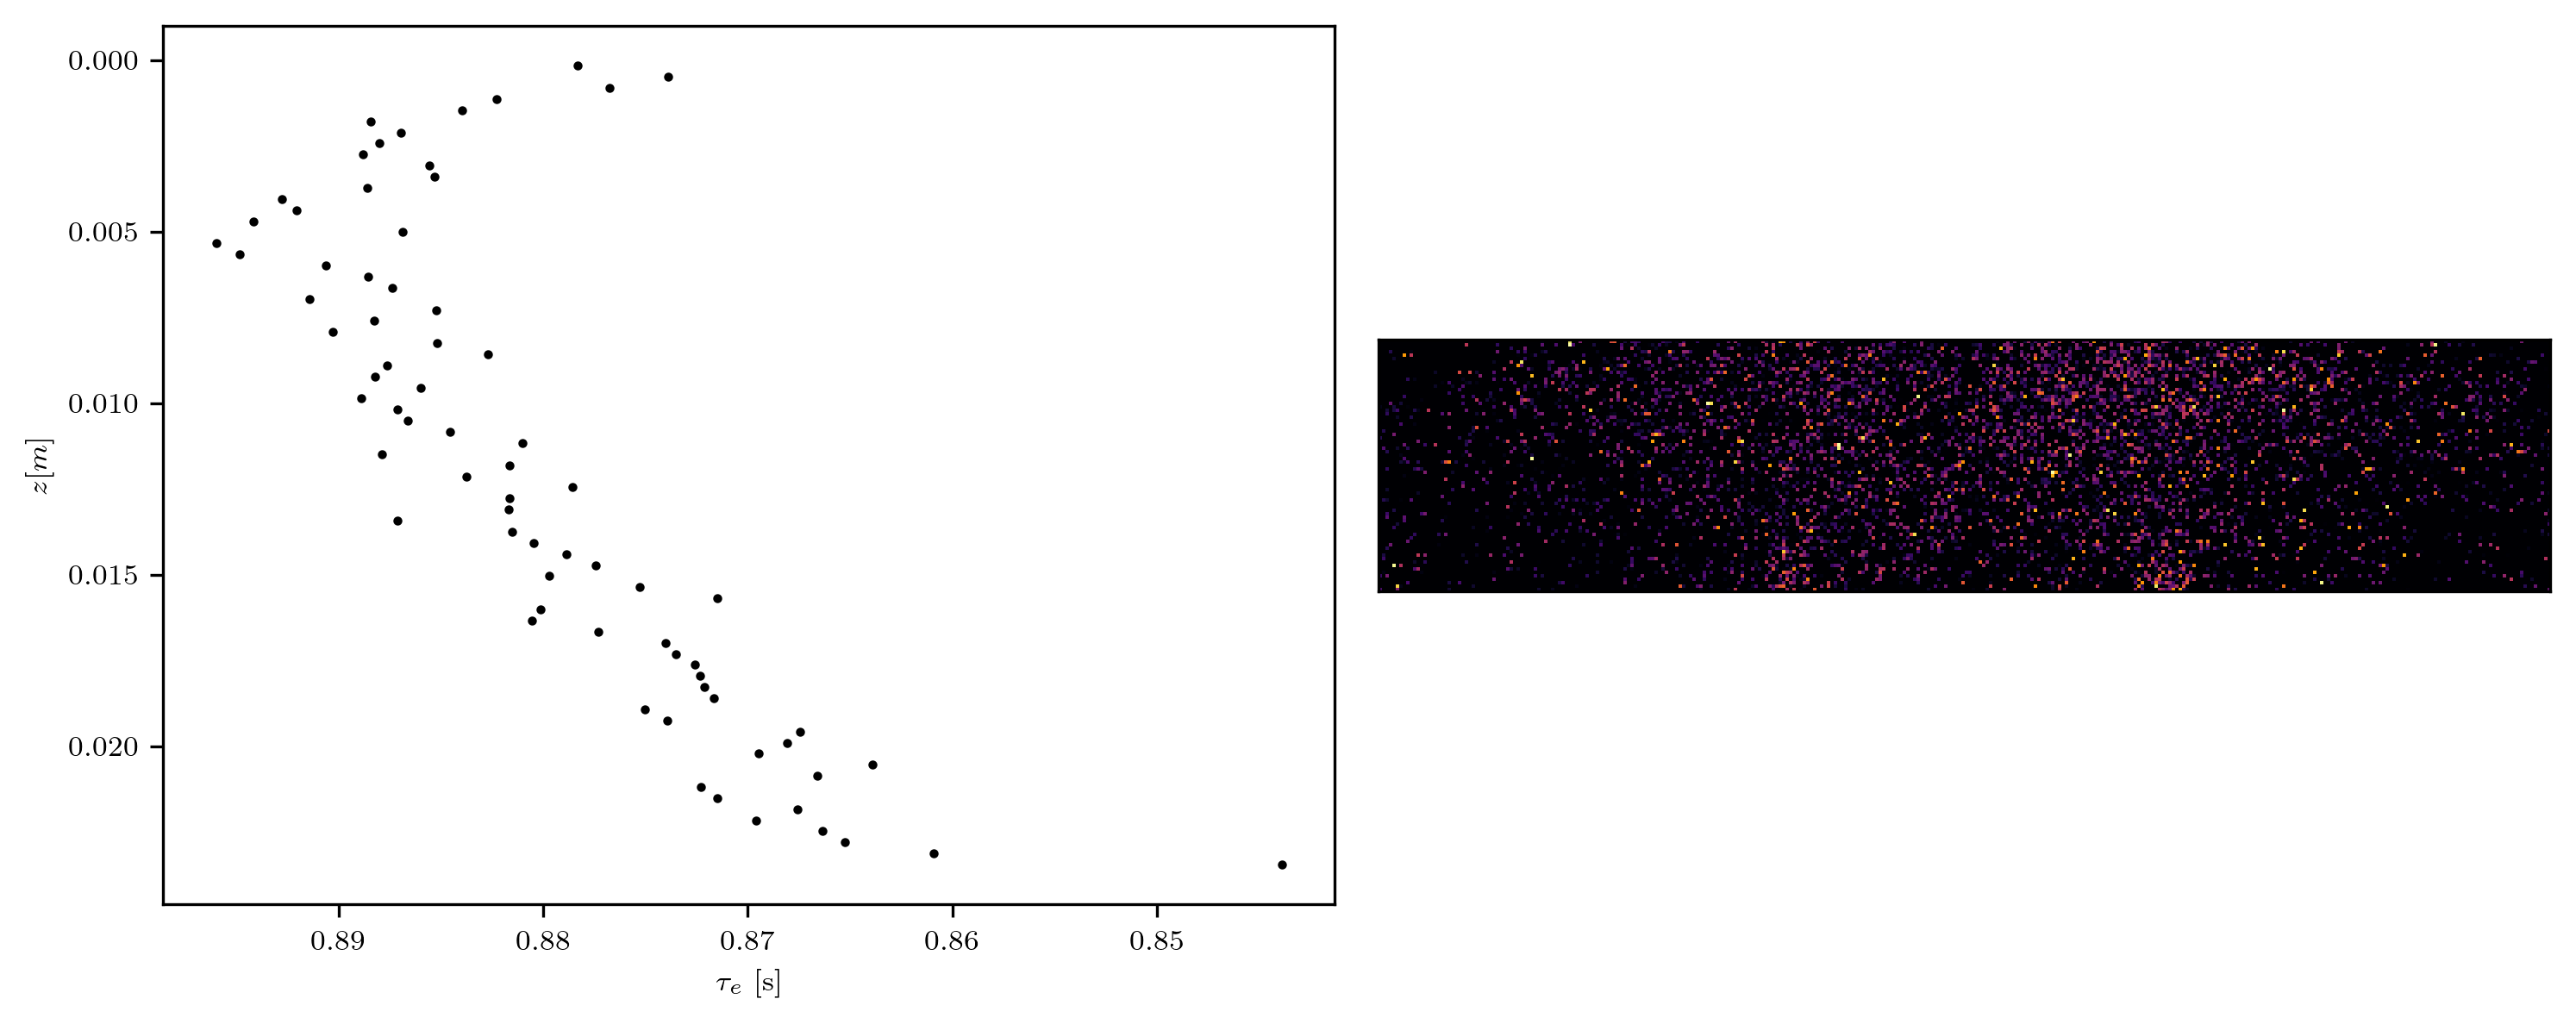

In [720]:
ms = 1.5

tw = 7
tau = 70

fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(121)#,aspect = 6.5)

ax1.plot(mean_depth_avg[tw][tau], z, 'ko', markersize=ms)
ax1.invert_yaxis()
ax1.invert_xaxis()
ax1.set_ylabel(r'$z [m]$')
ax1.set_xlabel(r'$\tau_e$ [s]')
# ax1.set_yticks([0,0.025,0.05])

# ax2 = ax1.twinx()
# ax2.plot(var_depth_avg[tw][tau], z, 'ro', markersize=ms)


frame = correlation_maps_cumulative[tw][tau]
masked_map = ma.masked_array(frame, mask = mask)
masked_map[masked_map <= 0] == .000000000000000000000001
masked_map = -(np.log(masked_map)/c) 

ax3 = plt.subplot(122)

ax3.imshow(masked_map[y_min:y_max,x_min:x_max],
           vmin=1e-7,
           vmax=1e-5,
           cmap='inferno_r')
ax3.set_xticks([])
ax3.set_yticks([])

plt.tight_layout()

# plt.savefig('/home/nakul/Documents/Python Scripts/DWS_Creep/MaterialsBoundaries/Boundaries/Bedform/Bedform_02_07_2022_E_profile_e-5', bbox_inches='tight')

In [721]:
# the structure of mean_depth_avg is: [tw][tau][z]
# restructuring so that is: [z][tw][tau]

In [723]:
test_swap = np.rollaxis(np.asarray(mean_depth_avg),2)

In [724]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
masked_map = -(np.log(masked_map)/c) 

/tmp/ipykernel_7784/3850289770.py:3: RuntimeWarning: invalid value encountered in log
  masked_map = -(np.log(masked_map)/c)


Text(0, 0.5, '$ \\langle \\dot{\\epsilon} (z) \\rangle$')

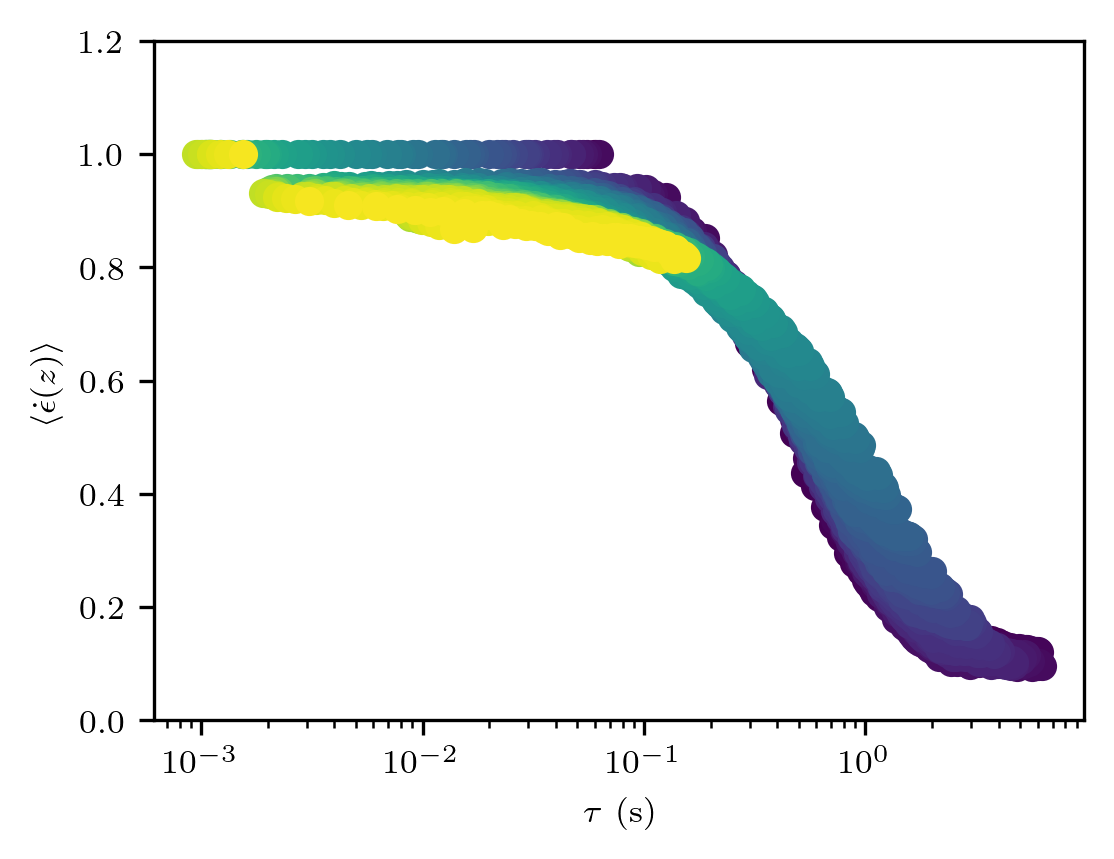

In [749]:
fig = plt.figure(figsize=(4, 3))
ax1 = plt.subplot(111)

xdata = np.arange(1, 101, 1)

n = len(z)

color = iter(cm.viridis(np.linspace(0, 1, n)))
labels = np.arange(0, n, 1)

for t in range(n-1):
    b=next(color)
    g = test_swap[t][3]
    strain = -(np.log(g)/c) 
    ax1.plot(xdata/test[t],g,'o',color = b)#,label = (z[t]))

ax1.set_xscale('log')
# ax1.set_yscale('log')

ax1.set_ylim([0,1.2])

# y = np.exp(-xdata)
# ax1.plot(xdata,y)

ax1.set_xlabel(r'$ \tau $ (s)')
ax1.set_ylabel(r'$ \langle \dot{\epsilon} (z) \rangle$')
# box = ax1.get_position()
# lgd = ax1.legend()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax1.legend(title = 'depth',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))

In [726]:
g = test_swap[20][3]
strain = -(np.log(g)/c) 

In [727]:
from scipy.optimize import curve_fit

def exponential_fit(x,τ):
    return  a*np.exp(-x / τ)

def log_fit(x,  c):
    """Return values from a general log function."""
    return a - np.log(1 + x/c) 

def power_fit(x,power):
    return a*(x**power)

In [728]:
xdata = np.arange(1, 101, 1)

#[z][tw]
g = test_swap[1][1]
strain = -(np.log(g)/c) 

xdata = xdata[1:]
ydata = g[1:]

a = np.max(ydata)

parameters_exp, parameterscov_exp = curve_fit(exponential_fit, xdata, ydata)#, bounds=(0,1))
parameters_power, parameterscov_exp = curve_fit(power_fit, xdata, ydata)#, bounds=(0,1))
parameters_log, parameterscov_log = curve_fit(log_fit, xdata, ydata)#, bounds=(0,1))


y_fit_exp = exponential_fit(xdata,*parameters_exp)
y_fit_power = power_fit(xdata,*parameters_power)
y_fit_log = log_fit(xdata,*parameters_log)

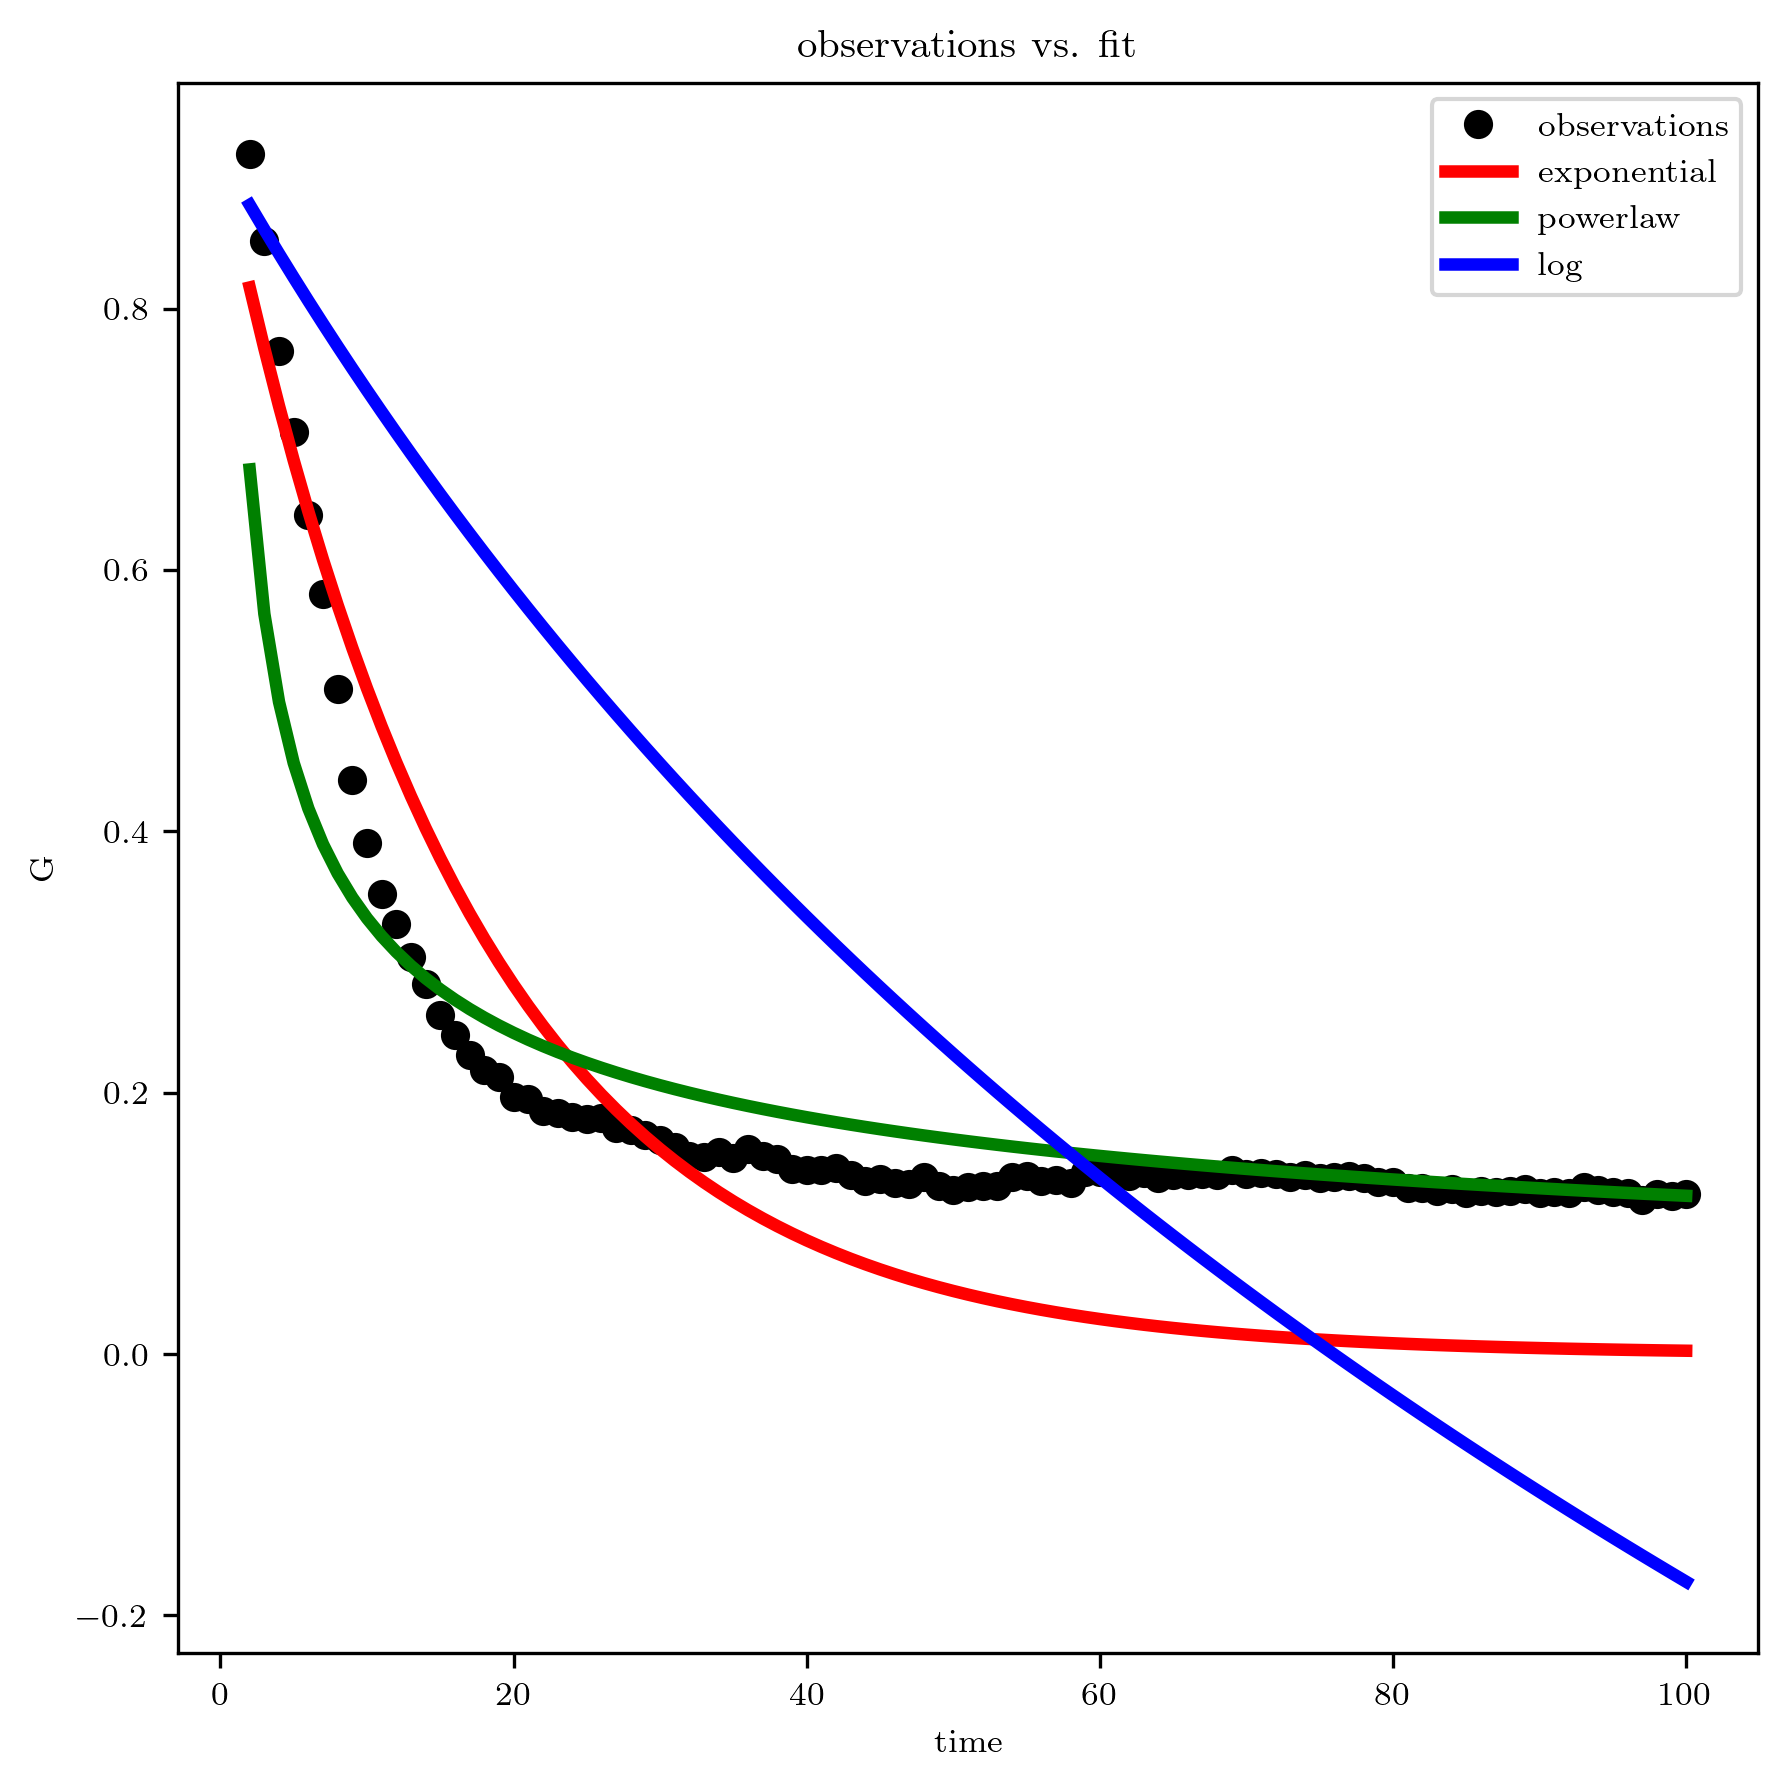

In [701]:
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(111)

ax1.plot(xdata,ydata, 'ok',linewidth = 3,label = 'observations')
ax1.plot(xdata,y_fit_exp,'r', linewidth = 3,label = 'exponential')
ax1.plot(xdata,y_fit_power,'g', linewidth = 3,label = 'powerlaw')
ax1.plot(xdata,y_fit_log,'b', linewidth = 3,label = 'log')

# ax1.set_xscale('log')
# ax1.set_yscale('log')

ax1.set_xlabel('time')
ax1.set_ylabel('G')
ax1.set_title('observations vs. fit')
ax1.legend()

# ax2.plot(xdata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)
# ax3.plot(ydata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)

plt.tight_layout()

In [621]:
# Assessing goodness of fit

residuals = ydata - power_fit(xdata,*parameters_power)
## residual sum of squares
ss_res = np.sum(residuals**2)
# total sum of squares
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared 

0.946350930125942

# Fitting exponential to G(z)

In [169]:
#write a loop to gather tau(z) for eath tw

In [810]:
n = len(z)    
m = 11

def t_efold_fit(correlation_function):
    
    
    xdata = np.arange(1, 101, 1)
    xdata = xdata[1:]

#     fitting_parameters = [[] for _ in range(n)]
    relaxation_profiles = [[] for _ in range(m)]
    
    
    for tw in range(m):
        tau = []
        for z in range(n):    
            ydata = correlation_function[z][tw]
            #the first data point drops precipitously and pollutes the fitting; i think its extraneous 
            a = np.max(ydata)
            ydata = ydata[1:]    
            popt, pcov = curve_fit(exponential_fit, xdata, ydata)#, bounds=(0,1))
            fitting_parameters = popt, pcov
            tau_temp = fitting_parameters[0][0]
        #         tau_temp = np.rint(tau_temp)
            tau.append(tau_temp)
            relaxation_profiles[tw] = tau
        del tau
    
    relaxation_profiles = np.asarray(relaxation_profiles)
    return relaxation_profiles

In [811]:
timescale_profiles = t_efold_fit(test_swap)

In [842]:
strain =  -(np.log(1/np.e) / c)

strain_rate_profiles = [[] for _ in range(11)]

for tw in range(11):
    strain_rate_profiles[tw] = strain/timescale_profiles[tw]

Text(0.5, 0, '$ \\langle \\dot{\\epsilon} (z) \\rangle$')

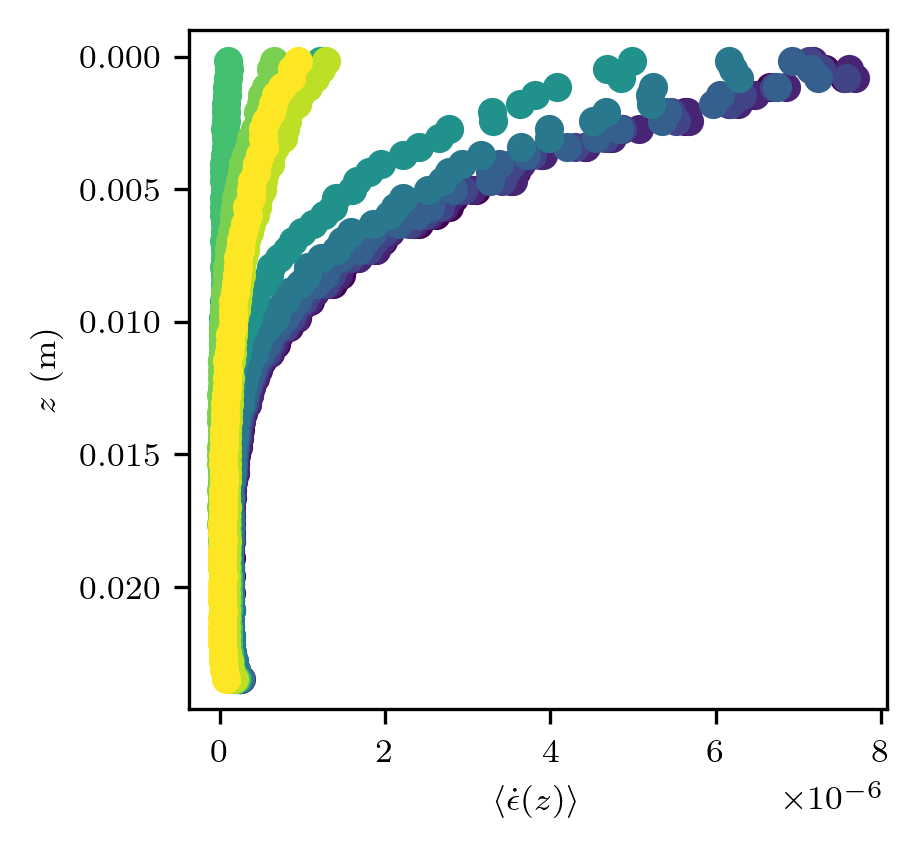

In [844]:
fig = plt.figure(figsize=(3, 3))
ax1 = plt.subplot(111)

xdata = np.arange(1, 101, 1)

n = 11

color = iter(cm.viridis(np.linspace(0, 1, n)))
labels = np.arange(0, n, 1)

for tw in range(n):
    b=next(color)
    ax1.plot(strain_rate_profiles[tw],z,'o',color = b)#,label = (z[t]))

ax1.invert_yaxis()

# ax1.set_xscale('log')
# ax1.set_yscale('log')

# ax1.set_ylim([0,1.2])

# y = np.exp(-xdata)
# ax1.plot(xdata,y)

ax1.set_ylabel(r'$ z $ (m)')
ax1.set_xlabel(r'$ \langle \dot{\epsilon} (z) \rangle$')
# box = ax1.get_position()
# lgd = ax1.legend()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax1.legend(title = 'depth',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))

Text(0, 0.5, '$ \\langle \\dot{\\epsilon} (z) \\rangle$')

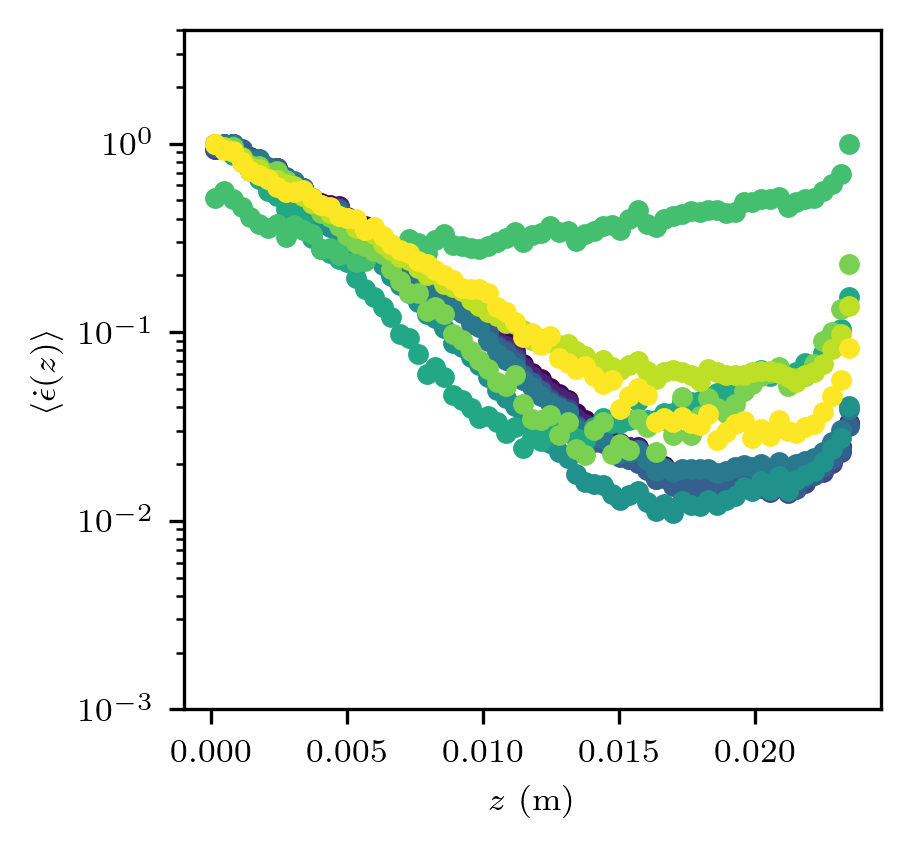

In [887]:
fig = plt.figure(figsize=(3, 3))
ax1 = plt.subplot(111)

xdata = np.arange(1, 101, 1)

ms = 4
n = 11

color = iter(cm.viridis(np.linspace(0, 1, n)))
labels = np.arange(0, n, 1)

for tw in range(n):
    b=next(color)
    ax1.plot(z,strain_rate_profiles[tw]/np.max(strain_rate_profiles[tw]),'o',markersize = ms,color = b)#,label = (z[t]))

ax1.set_yscale('log')
ax1.set_ylim([1e-3,4])

ax1.set_xlabel(r'$ z $ (m)')
ax1.set_ylabel(r'$ \langle \dot{\epsilon} (z) \rangle$')

# y = np.exp(xdata)
# ax1.plot(xdata,y)

# box = ax1.get_position()
# lgd = ax1.legend()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax1.legend(title = 'depth',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))

In [714]:
def normalize_profile(profile):
    profile_norm = profile/np.max(profile)
    profile_min = np.min(profile_norm)
    normalized = (profile_norm - profile_min)/(1-profile_min)
    return normalized

In [868]:
def exponential_fit(z,l):
    return  np.exp(-z/l)

xdata = z
n = 11
yfits = [[] for _ in range(n)]
ydata = [[] for _ in range(n)]
l = []

for i in range(n):
    ydata[i] = strain_rate_profiles[i] 
#     ydata[i] = normalize_profile(ydata[i])
    parameters, parameterscov = curve_fit(exponential_fit, xdata, ydata[i])#, bounds=(0,1))
    l.append(parameters[0])
    yfits[i] = exponential_fit(xdata,*parameters)

/tmp/ipykernel_7784/2975965940.py:2: RuntimeWarning: overflow encountered in exp
  return  np.exp(-z/l)


In [869]:
l

[1.3650927380584496e-05,
 1.3651543476839733e-05,
 1.3645017630409957e-05,
 1.3610674224399388e-05,
 1.3477748855250667e-05,
 1.3245078897594363e-05,
 1.1870050468988797e-05,
 1.0033012484926191e-05,
 1.135797209445327e-05,
 1.1916596863834504e-05,
 1.1655991265900824e-05]

Text(0, 0.5, '$ \\langle \\dot{\\epsilon} (z) \\rangle$')

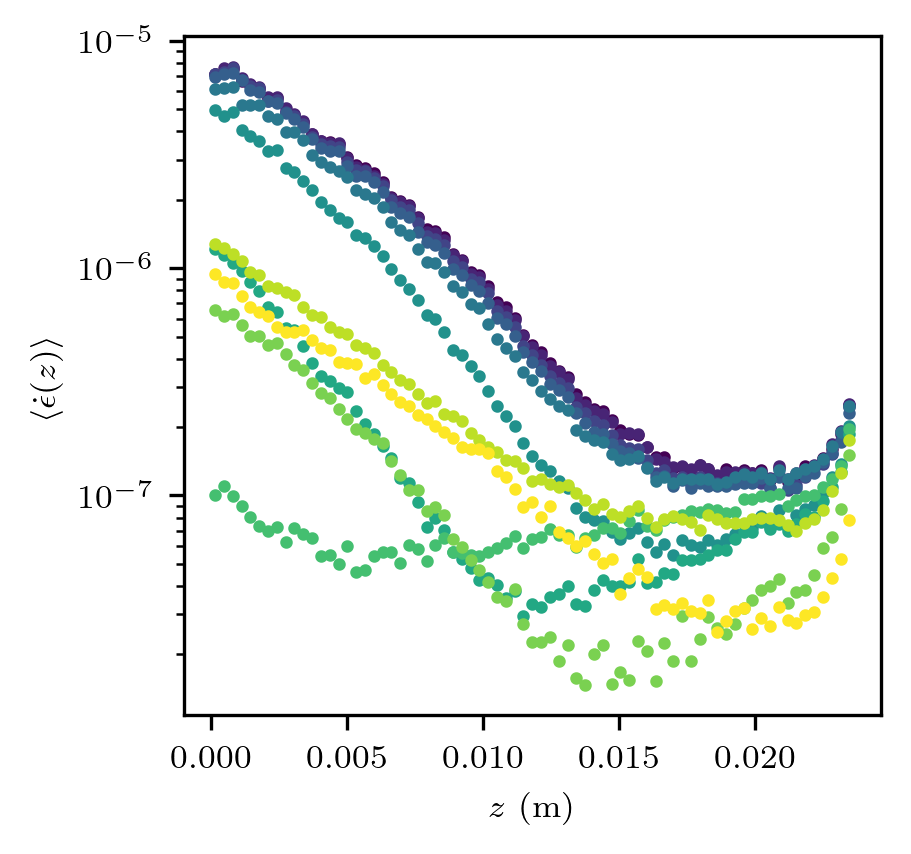

In [866]:
fig = plt.figure(figsize=(3, 3))
ax1 = plt.subplot(111)

xdata = np.arange(1, 101, 1)

ms = 2
n = 11

color = iter(cm.viridis(np.linspace(0, 1, n)))
labels = np.arange(0, n, 1)

for tw in range(n):
    b=next(color)
    ax1.plot(z,strain_rate_profiles[tw],'o',markersize = ms,color = b)#,label = (z[t]))

ax1.set_yscale('log')


ax1.set_xlabel(r'$ z $ (m)')
ax1.set_ylabel(r'$ \langle \dot{\epsilon} (z) \rangle$')
# box = ax1.get_position()
# lgd = ax1.legend()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax1.legend(title = 'depth',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))

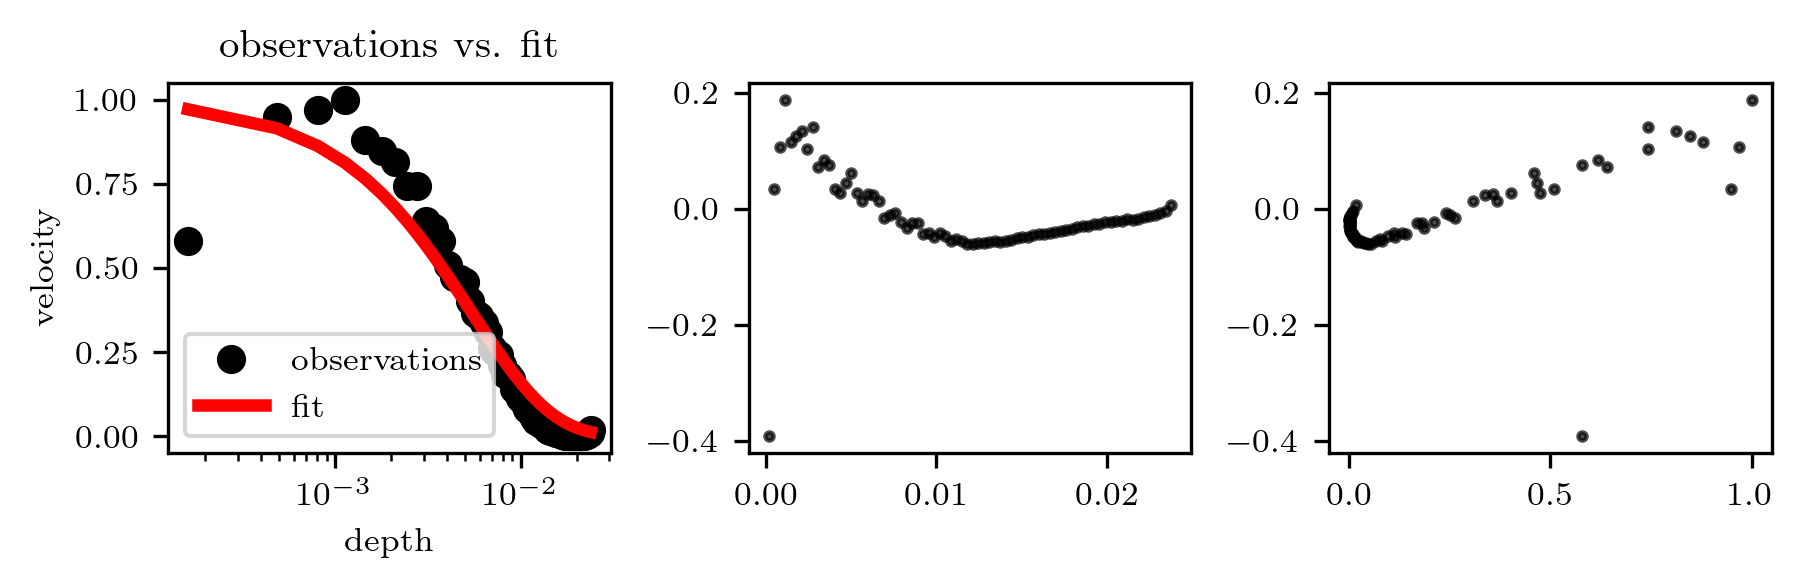

In [716]:
from scipy.optimize import curve_fit

def exponential_fit(z,l):
    return  np.exp(-z/l)


fig = plt.figure(figsize=(6, 2))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

xdata = z
ydata = normalize_profile(strain_profile)

parameters, parameterscov = curve_fit(exponential_fit, xdata, ydata)#, bounds=(0,1))

y_fit = exponential_fit(xdata,*parameters)

ax1.plot(xdata,ydata,'ko', linewidth = 3,label = 'observations')
ax1.plot(xdata,y_fit,'r', linewidth = 3,label = 'fit')
ax1.set_xscale('log')
# ax1.set_yscale('log')

ax1.set_xlabel('depth')
ax1.set_ylabel('velocity')
ax1.set_title('observations vs. fit')
ax1.legend()

ax2.plot(xdata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)
ax3.plot(ydata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)

plt.tight_layout()

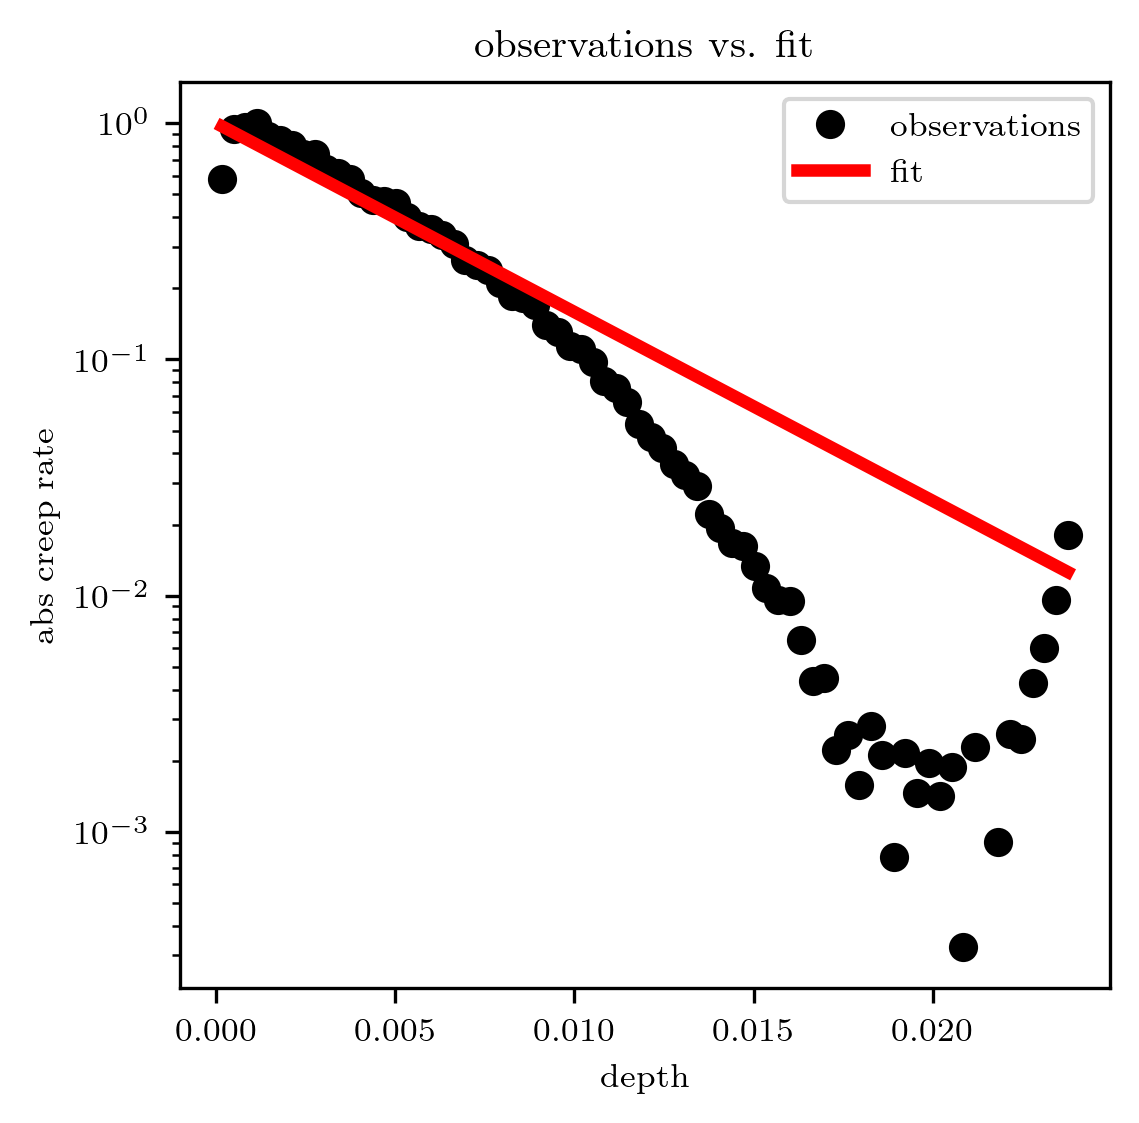

In [717]:
fig = plt.figure(figsize=(4, 4))
ax1 = plt.subplot(111)

ax1.plot(xdata,ydata,'ko', linewidth = 3,label = 'observations')
ax1.plot(xdata,y_fit,'r', linewidth = 3,label = 'fit')
# ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel('depth')
ax1.set_ylabel('abs creep rate')
ax1.set_title('observations vs. fit')
ax1.legend()

In [444]:
# Assessing goodness of fit

residuals = ydata - exponential_fit(xdata,*parameters)
## residual sum of squares
ss_res = np.sum(residuals**2)
# total sum of squares
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared 

0.9787187783686258

In [401]:
parameters

array([0.0055984])